This notebook was used to make `analyze_cut.py`

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Load-cibersort-results" data-toc-modified-id="Load-cibersort-results-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load cibersort results</a></span></li><li><span><a href="#Convergence-checks." data-toc-modified-id="Convergence-checks.-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Convergence checks.</a></span></li><li><span><a href="#Load-traces" data-toc-modified-id="Load-traces-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load traces</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plot</a></span><ul class="toc-item"><li><span><a href="#Make-these-plots-for-every-mixture." data-toc-modified-id="Make-these-plots-for-every-mixture.-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Make these plots for every mixture.</a></span></li></ul></li><li><span><a href="#Traceplots" data-toc-modified-id="Traceplots-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Traceplots</a></span></li><li><span><a href="#correlation-matrix" data-toc-modified-id="correlation-matrix-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>correlation matrix</a></span></li><li><span><a href="#Percentiles" data-toc-modified-id="Percentiles-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Percentiles</a></span></li><li><span><a href="#Output-summary-csv" data-toc-modified-id="Output-summary-csv-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Output summary csv</a></span></li><li><span><a href="#brief-validation" data-toc-modified-id="brief-validation-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>brief validation</a></span></li></ul></div>

In [1]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pystan
from time import time
from datetime import timedelta
import pickle
import dill

# import sys
# sys.path.append('..')
# import models


In [2]:
# verify kernel won't crash due to MKL issue from future imports
import sklearn.linear_model.tests.test_randomized_l1

In [10]:
import os
assert 'infino-rcc' in os.getcwd()
cohort_name = 'bladder'
cohort_name_cib = 'newbladder'
slug = 'bladder_counts_raw'
metric = 'counts'
processing='raw'
metric_processing = 'counts_raw'
#data_col = 'est_counts'
cutname = 'cut1'
PLOT_DIR = 'plots/{slug}/'.format(slug=slug)
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

In [75]:
make_all_plots = False # set to true for prod

In [11]:
stan_summary_loc = 'logs/{slug}/stansummary.{slug}.csv'.format(slug=slug)
trace_fnames = [
    'logs/{slug}/sampling_log.cohort.{slug}.txt_{num}.csv'.format(
        slug=slug, num=i) for i in range(4)
]

# bladder custom
stan_summary_loc = '/modelcache/experiments/{cohort_name}/stansummary.{cohort_name}.{metric_processing}.csv'.format(
    slug=slug, cohort_name=cohort_name, metric_processing=metric_processing)
trace_fnames = [
    '/modelcache/experiments/{cohort_name}/sampling_log.{cohort_name}.cut{slug}.txt_{num}.csv'.format(
        slug=slug, num=i, cohort_name=cohort_name, metric_processing=metric_processing) for i in range(4)
]

cohort_name, cohort_name_cib, metric, processing, metric_processing, cutname, slug, stan_summary_loc, PLOT_DIR, trace_fnames

('bladder',
 'newbladder',
 'counts',
 'raw',
 'counts_raw',
 'cut1',
 'bladder_counts_raw',
 '/modelcache/experiments/bladder/stansummary.bladder.counts_raw.csv',
 'plots/bladder_counts_raw/',
 ['/modelcache/experiments/bladder/sampling_log.bladder.cutbladder_counts_raw.txt_0.csv',
  '/modelcache/experiments/bladder/sampling_log.bladder.cutbladder_counts_raw.txt_1.csv',
  '/modelcache/experiments/bladder/sampling_log.bladder.cutbladder_counts_raw.txt_2.csv',
  '/modelcache/experiments/bladder/sampling_log.bladder.cutbladder_counts_raw.txt_3.csv'])

In [5]:
sns.set_style('darkgrid')

# Load cibersort results

In [117]:
cibersort_results = pd.read_csv('all_cohorts.cibersort_results.tsv', sep='\t') #, index_col=0)
cibersort_results.drop('Unnamed: 0', axis=1, inplace=True) # this is index from sub-dfs. not monotonically increasing
cibersort_results.head()

,Column,B_CD5,B_Memory,B_Naive,CD4_Central_Memory,CD4_Effector_Memory,CD4_Naive,CD4_Th1,CD4_Th17,CD4_Th2,...,P-value,Pearson Correlation,RMSE,cohort,metric,processing,data_col,cohort_sample_id,incut_sample_id,cutname
0,0,0.345292,0.109462,0.0,0.000000,0.000000,0.000000,0.402326,0.00000,0.052995,...,0.09,0.257156,1.036539,tcgakirc,counts,raw,est_counts,1,1,cut1
1,1,0.190512,0.338138,0.0,0.118218,0.000000,0.155444,0.000000,0.04093,0.000000,...,0.06,0.283903,1.058057,tcgakirc,counts,raw,est_counts,2,2,cut1
2,2,0.005919,0.382426,0.0,0.000000,0.117254,0.000000,0.418500,0.00000,0.034759,...,0.09,0.271856,1.045246,tcgakirc,counts,raw,est_counts,3,3,cut1
3,3,0.131206,0.257399,0.0,0.058128,0.045207,0.165655,0.270405,0.00000,0.010426,...,0.19,0.101305,1.144795,tcgakirc,counts,raw,est_counts,4,4,cut1
4,4,0.000000,0.431672,0.0,0.229889,0.000000,0.000000,0.173877,0.00000,0.044422,...,0.04,0.308456,1.029479,tcgakirc,counts,raw,est_counts,5,5,cut1


In [118]:
cibersort_results[['cohort', 'metric', 'processing', 'cutname']].drop_duplicates()

,cohort,metric,processing,cutname
0,tcgakirc,counts,raw,cut1
39,tcgakirc,counts,raw,cut2
79,tcgakirc,tpm,raw,cut1
118,tcgakirc,tpm,raw,cut2
158,tcgakirc,counts,corrected,cut1
197,tcgakirc,counts,corrected,cut2
237,tcgakirc,tpm,corrected,cut1
276,tcgakirc,tpm,corrected,cut2
316,newbladder,counts,raw,cut1
342,newbladder,tpm,raw,cut1


In [119]:
print(cibersort_results.shape)
cibersort_results = cibersort_results.loc[\
((cibersort_results['cohort'] == cohort_name_cib) & \
 (cibersort_results['metric'] == metric) & \
 (cibersort_results['processing'] == processing) & \
 (cibersort_results['cutname'] == cutname))]
print(cibersort_results.shape)

(420, 24)
(26, 24)


In [124]:
# rough confirmation that we did that right
assert all(cibersort_results['incut_sample_id'] == cibersort_results['Column'] + 1)
assert cibersort_results['incut_sample_id'].max() == cibersort_results.shape[0]

In [127]:
# reindex 0,1,2...
cibersort_results.reset_index(drop=True, inplace=True)

In [128]:
cibersort_results.index

RangeIndex(start=0, stop=26, step=1)

In [130]:
# should be same for all -- just want to get the column names
cibersort_classes = pd.read_csv('cohort_newbladder.cibersort.input.classes.datatype_est_counts.txt', sep='\t', header=None)
cibersort_classes.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,B_CD5,2,2,1,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
1,B_Memory,2,2,2,1,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
2,B_Naive,2,2,2,2,2,2,1,2,2,...,1,2,2,2,2,1,2,2,2,2
3,CD4_Central_Memory,2,2,2,2,2,2,2,2,2,...,2,1,2,2,2,2,2,1,2,2
4,CD4_Effector_Memory,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [131]:
#colnames = cibersort_results.columns[(cibersort_results.columns.str.startswith('B_') | cibersort_results.columns.str.startswith('CD4_') | cibersort_results.columns.str.startswith('CD8_'))]
colnames = cibersort_classes[0].values
assert len(colnames) == 13
colnames

array(['B_CD5', 'B_Memory', 'B_Naive', 'CD4_Central_Memory',
       'CD4_Effector_Memory', 'CD4_Naive', 'CD4_Th1', 'CD4_Th17',
       'CD4_Th2', 'CD4_Treg', 'CD8_Central_Memory', 'CD8_Effector',
       'CD8_Naive'], dtype=object)

In [132]:
rollups = {
    'B': [c for c in colnames if c.startswith('B_')],
    'CD4 T': [c for c in colnames if c.startswith('CD4_')],
    'CD8 T': [c for c in colnames if c.startswith('CD8_')]
}
rollups

{'B': ['B_CD5', 'B_Memory', 'B_Naive'],
 'CD4 T': ['CD4_Central_Memory',
  'CD4_Effector_Memory',
  'CD4_Naive',
  'CD4_Th1',
  'CD4_Th17',
  'CD4_Th2',
  'CD4_Treg'],
 'CD8 T': ['CD8_Central_Memory', 'CD8_Effector', 'CD8_Naive']}

In [133]:
# process cibersort
# for each mixture, compute the rollup sums
rollupsums = {}
for key in rollups:
    rollupsums[key] = cibersort_results[rollups[key]].sum(axis=1)
rollupsums_df = pd.DataFrame(rollupsums)
print(rollupsums_df.shape)
rollupsums_df.head()

(26, 3)


,B,CD4 T,CD8 T
0,0.437406,0.359439,0.203155
1,0.296216,0.496703,0.207081
2,0.260133,0.421284,0.318583
3,0.247254,0.552742,0.200005
4,0.120626,0.620227,0.259147


In [134]:
# sanity check 
assert np.allclose(rollupsums_df.sum(axis=1), 1.0)

# Convergence checks.

In [18]:
stan_summary = pd.read_csv(stan_summary_loc, comment='#')
stan_summary.head()

,name,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
0,lp__,-6.114740e+11,4.809510e+11,1.250690e+13,6.130050e+08,6.130130e+08,6.130150e+08,676.238,0.001065,1.003640
1,accept_stat__,7.975380e-01,2.414370e-02,2.458100e-01,2.058090e-01,8.968460e-01,9.977690e-01,103.656,0.000163,1.043890
2,stepsize__,1.007140e-02,4.259710e-03,3.261620e-01,5.873190e-04,8.778990e-04,3.561020e-03,5862.810,0.009237,0.999952
3,treedepth__,9.607880e+00,1.108710e-01,1.651270e+00,7.000000e+00,1.000000e+01,1.000000e+01,221.821,0.000349,1.020170
4,n_leapfrog__,9.639350e+02,1.685730e+01,2.296050e+02,1.460000e+02,1.023000e+03,1.023000e+03,185.519,0.000292,1.021370


In [19]:
stan_summary[stan_summary.name.str.startswith('sample2_x')].name.nunique()

338

In [22]:
# confirm we filtered properly
assert stan_summary[stan_summary.name.str.startswith('sample2_x')].name.nunique() / len(colnames) == cibersort_results.shape[0]
print(stan_summary[stan_summary.name.str.startswith('sample2_x')].name.nunique() / len(colnames),
      cibersort_results.shape[0])

26.0 26


In [23]:
def savefig(fig, *args, **kwargs):
    """
    Wrap figure.savefig defaulting to tight bounding box.
    From https://github.com/mwaskom/seaborn/blob/dfdd1126626f7ed0fe3737528edecb71346e9eb0/seaborn/axisgrid.py#L1840
    """
    kwargs.setdefault("bbox_inches", "tight")
    fig.savefig(*args, **kwargs)

In [24]:
# if this isn't true, stansummary failed (perhaps we ran it twice and appended)
assert stan_summary[stan_summary.name.str.startswith('sample2_x')]['R_hat'].dtype == 'float64'

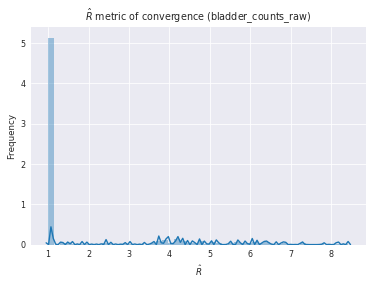

In [25]:
# convergence rhats


with sns.plotting_context('paper'):
    #f2 = plt.figure(figsize=(6,4))
    f2 = plt.figure()
    sns.distplot(stan_summary[stan_summary.name.str.startswith('sample2_x')]['R_hat'])
    #plt.title('Unknown mixture fraction estimates -- Rhat distribution')
    plt.title('$\hat{R}$ metric of convergence (%s)' % slug)
    plt.ylabel('Frequency')
    plt.xlabel('$\hat{R}$')
    #f2 = plt.gcf()
    savefig(f2, PLOT_DIR+'Rhat_sample2-x_dist.pdf', dpi=300)
    savefig(f2, PLOT_DIR+'Rhat_sample2-x_dist.png', dpi=300)

In [26]:
stan_summary[stan_summary.name.str.startswith('sample2_x')]['R_hat'].astype(float).describe()

count    338.000000
mean       1.894430
std        1.759641
min        1.003780
25%        1.014138
50%        1.020225
75%        1.086570
max        8.428360
Name: R_hat, dtype: float64

median 158.74599999999998
mean 142.960451331
min 2.02732


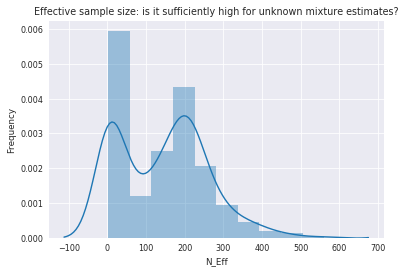

In [27]:
# convergence - N_eff

with sns.plotting_context('paper'):
    #f2 = plt.figure(figsize=(6,4)) # 8,6
    f2 = plt.figure()
    sns.distplot(stan_summary[stan_summary.name.str.startswith('sample2_x')]['N_Eff'])
    # Unknown mixture fraction estimates: effective sample size distribution
    plt.title('Effective sample size: is it sufficiently high for unknown mixture estimates?')

    print('median', stan_summary[stan_summary.name.str.startswith('sample2_x')]['N_Eff'].median())
    print('mean', stan_summary[stan_summary.name.str.startswith('sample2_x')]['N_Eff'].mean())
    print('min', stan_summary[stan_summary.name.str.startswith('sample2_x')]['N_Eff'].min())

    plt.ylabel('Frequency')
    #f2 = plt.gcf()
    savefig(f2, PLOT_DIR+'Neff_sample2-x_dist.pdf', dpi=300)
    savefig(f2, PLOT_DIR+'Neff_sample2-x_dist.png', dpi=300)

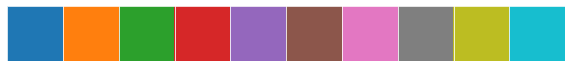

In [28]:
current_palette = sns.color_palette()
sns.palplot(current_palette)

median 0.00130591
mean 0.0450511322249


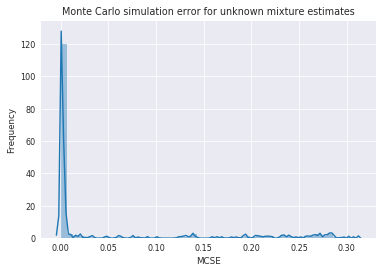

In [29]:
# convergence -- MCSE 
with sns.plotting_context('paper'):
    #f2 = plt.figure(figsize=(6,4))
    f2 = plt.figure()
    sns.distplot(stan_summary[stan_summary.name.str.startswith('sample2_x')]['MCSE'],
                 #kde_kws={'color':sns.color_palette()[2]}
                )
    #plt.axvline(x=stan_summary[stan_summary.name.str.startswith('sample2_x')]['MCSE'].median(),
    #            linestyle='dotted', lw=2.5, color=sns.color_palette()[2])
    print('median', stan_summary[stan_summary.name.str.startswith('sample2_x')]['MCSE'].median())
    print('mean', stan_summary[stan_summary.name.str.startswith('sample2_x')]['MCSE'].mean())
    #plt.title('Unknown mixture fraction estimates: Monte Carlo error distribution')
    plt.title('Monte Carlo simulation error for unknown mixture estimates')
    plt.ylabel('Frequency')
    #f2 = plt.gcf()
    savefig(f2, PLOT_DIR+'MCSE_sample2-x_dist.pdf', dpi=300)
    savefig(f2, PLOT_DIR+'MCSE_sample2-x_dist.png', dpi=300)

median 0.0166849
mean 0.0754747428698


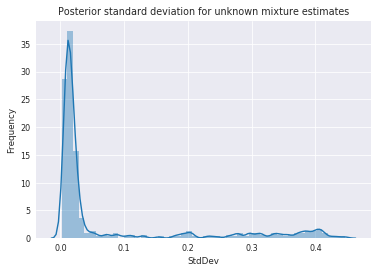

In [30]:
# convergence -- standard deviation
with sns.plotting_context('paper'):
    #f2 = plt.figure(figsize=(6,4))
    f2 = plt.figure()
    sns.distplot(stan_summary[stan_summary.name.str.startswith('sample2_x')]['StdDev'])
    # plt.axvline(x=stan_summary[stan_summary.name.str.startswith('sample2_x')]['StdDev'].median(),
    #             linestyle='dotted', lw=2.5, color=sns.color_palette()[2])
    print('median', stan_summary[stan_summary.name.str.startswith('sample2_x')]['StdDev'].median())
    print('mean', stan_summary[stan_summary.name.str.startswith('sample2_x')]['StdDev'].mean())
    plt.title('Posterior standard deviation for unknown mixture estimates')
    plt.ylabel('Frequency')
    #f2 = plt.gcf()
    savefig(f2, PLOT_DIR+'StdDev_sample2-x_dist.pdf', dpi=300)
    savefig(f2, PLOT_DIR+'StdDev_sample2-x_dist.png', dpi=300)

In [31]:
stan_summary[stan_summary.name.str.startswith('sample2_x')]['StdDev'].describe()

count    338.000000
mean       0.075475
std        0.124098
min        0.002022
25%        0.010865
50%        0.016685
75%        0.033279
max        0.446562
Name: StdDev, dtype: float64

In [32]:
summary_ranges = stan_summary[stan_summary.name.str.startswith('sample2_x')][[
    'R_hat', 'StdDev', 'MCSE', 'N_Eff'
]].astype(float).describe()
summary_ranges.to_csv(PLOT_DIR + "summarystats.{slug}.tsv".format(slug=slug), sep='\t')
summary_ranges

,R_hat,StdDev,MCSE,N_Eff
count,338.000000,338.000000,338.000000,338.000000
mean,1.894430,0.075475,0.045051,142.960451
std,1.759641,0.124098,0.089338,115.384081
min,1.003780,0.002022,0.000254,2.027320
25%,1.014138,0.010865,0.000763,16.421300
50%,1.020225,0.016685,0.001306,158.746000
75%,1.086570,0.033279,0.007017,218.553750
max,8.428360,0.446562,0.310062,560.611000


# Load traces

In [33]:
# have to load in the full traces
cols_we_want = stan_summary[stan_summary.name.str.startswith('sample2_x')].name.values
cols_we_want

array(['sample2_x[1,1]', 'sample2_x[1,2]', 'sample2_x[1,3]',
       'sample2_x[1,4]', 'sample2_x[1,5]', 'sample2_x[1,6]',
       'sample2_x[1,7]', 'sample2_x[1,8]', 'sample2_x[1,9]',
       'sample2_x[1,10]', 'sample2_x[1,11]', 'sample2_x[1,12]',
       'sample2_x[1,13]', 'sample2_x[2,1]', 'sample2_x[2,2]',
       'sample2_x[2,3]', 'sample2_x[2,4]', 'sample2_x[2,5]',
       'sample2_x[2,6]', 'sample2_x[2,7]', 'sample2_x[2,8]',
       'sample2_x[2,9]', 'sample2_x[2,10]', 'sample2_x[2,11]',
       'sample2_x[2,12]', 'sample2_x[2,13]', 'sample2_x[3,1]',
       'sample2_x[3,2]', 'sample2_x[3,3]', 'sample2_x[3,4]',
       'sample2_x[3,5]', 'sample2_x[3,6]', 'sample2_x[3,7]',
       'sample2_x[3,8]', 'sample2_x[3,9]', 'sample2_x[3,10]',
       'sample2_x[3,11]', 'sample2_x[3,12]', 'sample2_x[3,13]',
       'sample2_x[4,1]', 'sample2_x[4,2]', 'sample2_x[4,3]',
       'sample2_x[4,4]', 'sample2_x[4,5]', 'sample2_x[4,6]',
       'sample2_x[4,7]', 'sample2_x[4,8]', 'sample2_x[4,9]',
       'samp

In [34]:
cols_we_want_renamed  = [c.replace('[', '.').replace(']', '').replace(',', '.') for c in cols_we_want]
cols_we_want_renamed

['sample2_x.1.1',
 'sample2_x.1.2',
 'sample2_x.1.3',
 'sample2_x.1.4',
 'sample2_x.1.5',
 'sample2_x.1.6',
 'sample2_x.1.7',
 'sample2_x.1.8',
 'sample2_x.1.9',
 'sample2_x.1.10',
 'sample2_x.1.11',
 'sample2_x.1.12',
 'sample2_x.1.13',
 'sample2_x.2.1',
 'sample2_x.2.2',
 'sample2_x.2.3',
 'sample2_x.2.4',
 'sample2_x.2.5',
 'sample2_x.2.6',
 'sample2_x.2.7',
 'sample2_x.2.8',
 'sample2_x.2.9',
 'sample2_x.2.10',
 'sample2_x.2.11',
 'sample2_x.2.12',
 'sample2_x.2.13',
 'sample2_x.3.1',
 'sample2_x.3.2',
 'sample2_x.3.3',
 'sample2_x.3.4',
 'sample2_x.3.5',
 'sample2_x.3.6',
 'sample2_x.3.7',
 'sample2_x.3.8',
 'sample2_x.3.9',
 'sample2_x.3.10',
 'sample2_x.3.11',
 'sample2_x.3.12',
 'sample2_x.3.13',
 'sample2_x.4.1',
 'sample2_x.4.2',
 'sample2_x.4.3',
 'sample2_x.4.4',
 'sample2_x.4.5',
 'sample2_x.4.6',
 'sample2_x.4.7',
 'sample2_x.4.8',
 'sample2_x.4.9',
 'sample2_x.4.10',
 'sample2_x.4.11',
 'sample2_x.4.12',
 'sample2_x.4.13',
 'sample2_x.5.1',
 'sample2_x.5.2',
 'sample2_x.

In [35]:
all_traces = []
for (i, fname) in zip(range(4), trace_fnames):
    print('loading:', i, fname)
    trace_i = pd.read_csv(fname, comment='#', usecols=cols_we_want_renamed)
    trace_i['trace_id'] = i
    trace_i['iter'] = trace_i.index
    all_traces.append(trace_i)

loading: 0 /modelcache/experiments/bladder/sampling_log.bladder.cutbladder_counts_raw.txt_0.csv
loading: 1 /modelcache/experiments/bladder/sampling_log.bladder.cutbladder_counts_raw.txt_1.csv
loading: 2 /modelcache/experiments/bladder/sampling_log.bladder.cutbladder_counts_raw.txt_2.csv
loading: 3 /modelcache/experiments/bladder/sampling_log.bladder.cutbladder_counts_raw.txt_3.csv


In [36]:
all_traces_df = pd.concat(all_traces)
print(all_traces_df.shape)
all_traces_df.head()

(8000, 340)


,sample2_x.1.1,sample2_x.2.1,sample2_x.3.1,sample2_x.4.1,sample2_x.5.1,sample2_x.6.1,sample2_x.7.1,sample2_x.8.1,sample2_x.9.1,sample2_x.10.1,...,sample2_x.19.13,sample2_x.20.13,sample2_x.21.13,sample2_x.22.13,sample2_x.23.13,sample2_x.24.13,sample2_x.25.13,sample2_x.26.13,trace_id,iter
0,0.071325,0.025302,0.06041,0.364197,0.011548,0.015664,0.350165,0.029603,0.014322,0.051758,...,0.076304,0.07389,0.0415,0.05562,0.018112,0.023271,0.021696,0.039032,0,0
1,0.071325,0.025302,0.06041,0.364197,0.011548,0.015664,0.350165,0.029603,0.014322,0.051758,...,0.076304,0.07389,0.0415,0.05562,0.018112,0.023271,0.021696,0.039032,0,1
2,0.071325,0.025302,0.06041,0.364197,0.011548,0.015664,0.350165,0.029603,0.014322,0.051758,...,0.076304,0.07389,0.0415,0.05562,0.018112,0.023271,0.021696,0.039032,0,2
3,0.071325,0.025302,0.06041,0.364197,0.011548,0.015664,0.350165,0.029603,0.014322,0.051758,...,0.076304,0.07389,0.0415,0.05562,0.018112,0.023271,0.021696,0.039032,0,3
4,0.071325,0.025302,0.06041,0.364197,0.011548,0.015664,0.350165,0.029603,0.014322,0.051758,...,0.076304,0.07389,0.0415,0.05562,0.018112,0.023271,0.021696,0.039032,0,4


In [37]:
all_traces_df2 = pd.melt(all_traces_df, id_vars=['iter','trace_id'], value_name='estimate', var_name='variable')
all_traces_df2.head()

,iter,trace_id,variable,estimate
0,0,0,sample2_x.1.1,0.071325
1,1,0,sample2_x.1.1,0.071325
2,2,0,sample2_x.1.1,0.071325
3,3,0,sample2_x.1.1,0.071325
4,4,0,sample2_x.1.1,0.071325


In [38]:
var_ids = all_traces_df2.variable.str.extract('sample2_x.(?P<sample_id>\d+).(?P<subset_id>\d+)')
var_ids.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


,sample_id,subset_id
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


In [39]:
all_traces_df3= pd.concat([all_traces_df2, var_ids], axis=1) 
all_traces_df3.head()

,iter,trace_id,variable,estimate,sample_id,subset_id
0,0,0,sample2_x.1.1,0.071325,1,1
1,1,0,sample2_x.1.1,0.071325,1,1
2,2,0,sample2_x.1.1,0.071325,1,1
3,3,0,sample2_x.1.1,0.071325,1,1
4,4,0,sample2_x.1.1,0.071325,1,1


In [40]:
all_traces_df3['subset_id'] = all_traces_df3['subset_id'].astype(int)
all_traces_df3['sample_id'] = all_traces_df3['sample_id'].astype(int)

In [41]:
all_traces_df3.sample_id.max(), all_traces_df3.subset_id.max()

(26, 13)

In [42]:
sample2_xs = stan_summary[stan_summary.name.str.startswith('sample2_x')]['Mean'].values.reshape(all_traces_df3.sample_id.max(), all_traces_df3.subset_id.max()) # (10,13) before
sample2_xs.shape

(26, 13)

In [43]:
mixture_estimates = pd.DataFrame(sample2_xs, columns=colnames)
mixture_estimates

,B_CD5,B_Memory,B_Naive,CD4_Central_Memory,CD4_Effector_Memory,CD4_Naive,CD4_Th1,CD4_Th17,CD4_Th2,CD4_Treg,CD8_Central_Memory,CD8_Effector,CD8_Naive
0,0.301840,0.418701,0.109278,0.011418,0.011629,0.005961,0.017631,0.077871,0.009423,0.009907,0.010433,0.006488,0.009421
1,0.476151,0.041587,0.232955,0.002356,0.004587,0.002788,0.005585,0.224530,0.002195,0.001795,0.001385,0.002051,0.002036
2,0.468500,0.050482,0.226831,0.004587,0.003445,0.003938,0.005593,0.222347,0.003309,0.003563,0.002768,0.002291,0.002345
3,0.417554,0.156685,0.184734,0.006394,0.006709,0.003086,0.010523,0.185207,0.006634,0.006612,0.005003,0.005428,0.005432
4,0.237287,0.699579,0.007396,0.007200,0.005334,0.010567,0.004540,0.004982,0.004835,0.004214,0.004766,0.004130,0.005169
5,0.290861,0.459201,0.098191,0.012946,0.009839,0.007672,0.018175,0.054639,0.012166,0.010032,0.009991,0.006394,0.009892
6,0.364287,0.339898,0.143401,0.007540,0.005674,0.003055,0.008047,0.108073,0.004271,0.004284,0.003861,0.004021,0.003587
7,0.233127,0.581008,0.038723,0.015711,0.014177,0.009790,0.019375,0.023011,0.013739,0.013910,0.013257,0.011717,0.012456
8,0.230000,0.593823,0.028915,0.016055,0.013122,0.010285,0.019080,0.020375,0.016267,0.014868,0.013371,0.011308,0.012530
9,0.216931,0.630743,0.005708,0.006326,0.004375,0.097143,0.003970,0.003466,0.005235,0.005371,0.006141,0.010137,0.004455


In [44]:
import re
subset_names = [re.sub(string=x, pattern='(.*)\[(.*)\]', repl='\\2') for x in mixture_estimates.columns]
subset_names

['B_CD5',
 'B_Memory',
 'B_Naive',
 'CD4_Central_Memory',
 'CD4_Effector_Memory',
 'CD4_Naive',
 'CD4_Th1',
 'CD4_Th17',
 'CD4_Th2',
 'CD4_Treg',
 'CD8_Central_Memory',
 'CD8_Effector',
 'CD8_Naive']

In [45]:
# switch to names from stansummary
all_traces_df3['subset_name'] = all_traces_df3.subset_id.apply(lambda i: subset_names[i-1])
all_traces_df3.head()

,iter,trace_id,variable,estimate,sample_id,subset_id,subset_name
0,0,0,sample2_x.1.1,0.071325,1,1,B_CD5
1,1,0,sample2_x.1.1,0.071325,1,1,B_CD5
2,2,0,sample2_x.1.1,0.071325,1,1,B_CD5
3,3,0,sample2_x.1.1,0.071325,1,1,B_CD5
4,4,0,sample2_x.1.1,0.071325,1,1,B_CD5


In [46]:
# IMPORTANT: drop the warmup samples!!!!!
warmup = 1000
# this should show a wide range
#all_traces_df3.iter.hist()
all_traces_df3.iter.describe()[['min', 'max']]

min       0.0
max    1999.0
Name: iter, dtype: float64

In [47]:
# drop warmups
all_traces_df3 = all_traces_df3.loc[all_traces_df3['iter']>=1000,]
all_traces_df3['iter'] -= 1000
# this should be better now
#all_traces_df3.iter.hist()
all_traces_df3.iter.describe()[['min', 'max']]

min      0.0
max    999.0
Name: iter, dtype: float64

In [48]:
# combine iteration numbers across traces -- i.e. line them up from 0 to 4000, not 4 versions of 0 to 1000
#(all_traces_df3['trace_id']*1000 + all_traces_df3['iter']).hist()
(all_traces_df3['trace_id']*1000 + all_traces_df3['iter']).describe()[['min', 'max']]

min       0.0
max    3999.0
dtype: float64

In [49]:
assert (all_traces_df3['trace_id']*1000 + all_traces_df3['iter']).describe()['max'] == 3999

In [50]:
all_traces_df3['combined_iter_number'] = (all_traces_df3['trace_id']*1000 + all_traces_df3['iter'])

In [51]:
#assert all_traces_df3.shape[0] / 10 / 13 / 4 == 1000.
assert all_traces_df3.shape[0] / all_traces_df3.sample_id.max() / all_traces_df3.subset_id.max() / 4 == 1000.

# Plot

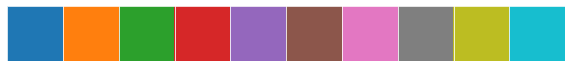

In [52]:
current_palette = sns.color_palette()
sns.palplot(current_palette)

In [53]:
subset_names, colnames

(['B_CD5',
  'B_Memory',
  'B_Naive',
  'CD4_Central_Memory',
  'CD4_Effector_Memory',
  'CD4_Naive',
  'CD4_Th1',
  'CD4_Th17',
  'CD4_Th2',
  'CD4_Treg',
  'CD8_Central_Memory',
  'CD8_Effector',
  'CD8_Naive'],
 array(['B_CD5', 'B_Memory', 'B_Naive', 'CD4_Central_Memory',
        'CD4_Effector_Memory', 'CD4_Naive', 'CD4_Th1', 'CD4_Th17',
        'CD4_Th2', 'CD4_Treg', 'CD8_Central_Memory', 'CD8_Effector',
        'CD8_Naive'], dtype=object))

In [54]:
rollups

{'B': ['B_CD5', 'B_Memory', 'B_Naive'],
 'CD4 T': ['CD4_Central_Memory',
  'CD4_Effector_Memory',
  'CD4_Naive',
  'CD4_Th1',
  'CD4_Th17',
  'CD4_Th2',
  'CD4_Treg'],
 'CD8 T': ['CD8_Central_Memory', 'CD8_Effector', 'CD8_Naive']}

In [55]:
def label_rollup(rollups, x):
    for key in rollups.keys():
        if x in rollups[key]:
            return key
    return None

In [56]:
all_traces_df3['rollup'] = all_traces_df3.subset_name.apply(lambda x: label_rollup(rollups, x))

all_traces_df3.rollup.value_counts()

CD4 T    728000
B        312000
CD8 T    312000
Name: rollup, dtype: int64

In [57]:
samples_rolledup = all_traces_df3.groupby(['sample_id', 'combined_iter_number', 'rollup']).estimate.sum().reset_index()
samples_rolledup.head()

,sample_id,combined_iter_number,rollup,estimate
0,1,0,B,0.905751
1,1,0,CD4 T,0.071039
2,1,0,CD8 T,0.023210
3,1,1,B,0.903543
4,1,1,CD4 T,0.086019


In [58]:
# cibersort results
rollupsums_df.head()

,B,CD4 T,CD8 T
0,0.437406,0.359439,0.203155
1,0.296216,0.496703,0.207081
2,0.260133,0.421284,0.318583
3,0.247254,0.552742,0.200005
4,0.120626,0.620227,0.259147


In [59]:
cleaner_traces = all_traces_df3.copy()
cleaner_traces['subset_name'] = cleaner_traces['subset_name'].str.replace(
    '_', ' ')
cleaner_traces['subset_name'].value_counts()

CD4 Naive              104000
CD4 Th17               104000
B Naive                104000
CD8 Central Memory     104000
CD8 Naive              104000
CD4 Th1                104000
CD4 Th2                104000
B Memory               104000
CD4 Effector Memory    104000
CD8 Effector           104000
B CD5                  104000
CD4 Treg               104000
CD4 Central Memory     104000
Name: subset_name, dtype: int64

In [60]:
cleaner_traces.head()

,iter,trace_id,variable,estimate,sample_id,subset_id,subset_name,combined_iter_number,rollup
1000,0,0,sample2_x.1.1,0.327539,1,1,B CD5,0,B
1001,1,0,sample2_x.1.1,0.325144,1,1,B CD5,1,B
1002,2,0,sample2_x.1.1,0.322562,1,1,B CD5,2,B
1003,3,0,sample2_x.1.1,0.309711,1,1,B CD5,3,B
1004,4,0,sample2_x.1.1,0.319754,1,1,B CD5,4,B


In [61]:
samples_rolledup.head()

,sample_id,combined_iter_number,rollup,estimate
0,1,0,B,0.905751
1,1,0,CD4 T,0.071039
2,1,0,CD8 T,0.023210
3,1,1,B,0.903543
4,1,1,CD4 T,0.086019


In [62]:
merged_samples_1 = cleaner_traces[['sample_id', 'combined_iter_number', 'subset_name', 'estimate']].copy()
merged_samples_1['type'] = 'subset'
merged_samples_2 = samples_rolledup.copy()
merged_samples_2.columns = [c.replace('rollup', 'subset_name') for c in merged_samples_2.columns]
merged_samples_2['type'] = 'rollup'
merged_samples = pd.concat([merged_samples_1, merged_samples_2])
merged_samples.type.value_counts()

subset    1352000
rollup     312000
Name: type, dtype: int64

In [63]:
#sns.set_context('paper')
sns.set_style("darkgrid")

In [64]:
def extract_values_for_mixture_by_id(key):
    """
    key: 1-indexed, meaning mixture 1 to mixture 10
    
    based on:
    for (key, grp), \
            (_, groundtruth_base), \
            friendly_title, \
            (_, cib_vals_base), \
            (mixID_rolledup, groundtruth_rolledup), \
            (_, cib_vals_rolledup) in zip(merged_samples.groupby('sample_id'),
                                          cleaner_gt.iterrows(),
                                          #friendly_mixture_descriptions2,
                                          friendly_mixture_descriptions,
                                          example_result[cib_class_names].iterrows(),
                                          rollup_groundtruth.groupby('mixID'),
                                          rollupsums_df.iterrows()
    """
    grp = merged_samples[merged_samples['sample_id'] == key]
    #groundtruth_base = cleaner_gt.iloc[key-1]
    cib_vals_base = cibersort_results[colnames].iloc[key - 1]
    #groundtruth_rolledup = rollup_groundtruth[rollup_groundtruth['mixID'] == key-1]
    cib_vals_rolledup = rollupsums_df.iloc[key - 1]

    return (key,
            grp,
            #groundtruth_base,
            cib_vals_base,
            #groundtruth_rolledup,
            cib_vals_rolledup)

In [65]:
col_order = [[cat] + rollups[cat] for cat in rollups]
col_order = [item for sublist in col_order for item in sublist] # flatten: https://stackoverflow.com/questions/952914/making-a-flat-list-out-of-list-of-lists-in-python
col_order = [c.replace('_', ' ') for c in col_order]
col_order

['B',
 'B CD5',
 'B Memory',
 'B Naive',
 'CD4 T',
 'CD4 Central Memory',
 'CD4 Effector Memory',
 'CD4 Naive',
 'CD4 Th1',
 'CD4 Th17',
 'CD4 Th2',
 'CD4 Treg',
 'CD8 T',
 'CD8 Central Memory',
 'CD8 Effector',
 'CD8 Naive']

In [66]:
def plot_single_mixture_results(mixture_info, friendly_title):
    #flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"] # http://seaborn.pydata.org/tutorial/color_palettes.html
    #sns.palplot(flatui)
    paired_colors = sns.color_palette("Paired_r", 12)
    #sns.palplot(paired_colors)
    
    (key,
     grp,
     #groundtruth_base,
     cib_vals_base,
     #groundtruth_rolledup,
     cib_vals_rolledup
    ) = mixture_info

    with sns.plotting_context('paper'):
        f, ax = plt.subplots( figsize=(12,8))
        g = sns.boxplot(data = grp,
                       y='subset_name',
                       x='estimate',
                       ax=ax,
                       hue='type',
                       order=col_order,
                        # some additional parameters that we think may help:
                        saturation=1,
                        linewidth=1, # not sure about this one
                        dodge=False, # avoid hue nesting
                       #palette=[flatui[0], flatui[1]]
                        palette=paired_colors[0:2]
                       )
        g.set_title(friendly_title) 

#         # ground truth
#         gt1 = pd.DataFrame(groundtruth_base).reset_index()
#         gt1.columns = ['rollup', 'estimate']
#         gt1['type'] = 'subset'
#         gt2 = groundtruth_rolledup[['rollup', 'estimate']].copy()
#         gt2['type'] = 'rollup'
#         gt = pd.concat([gt1, gt2])

#         sns.stripplot(
#             x="estimate",
#             y="rollup",
#             data=gt,
#             hue='type',
#             order=col_order,
#             linewidth=0,
#             size=15,
#             alpha=.9,
#             marker=(5, 1),
#             #palette=[flatui[5], flatui[3]],
#             palette=paired_colors[2:4],
#             zorder=5,
#             jitter=False,
#             label='Ground Truth' # https://github.com/mwaskom/seaborn/issues/940 -- without this line, the stars aren't shown in legend entries made by "hue" param; instead you get a ton of dupe Ground Truth star labels
#         )

        # add cibersort points
        cb_base = pd.DataFrame(cib_vals_base).reset_index()
        cb_base.columns = ['SubSet', 'estimate']
        cb_base['type'] = 'subset'

        cb_rolledup = pd.DataFrame(cib_vals_rolledup).reset_index()
        cb_rolledup.columns = ['SubSet', 'estimate']
        cb_rolledup['type'] = 'rollup'

        cb = pd.concat([cb_base, cb_rolledup])
        cb.SubSet = cb.SubSet.str.replace('_', ' ') # normalize names

        sns.stripplot(
            x="estimate",
            y="SubSet",
            data=cb,
            hue='type',
            order=col_order,
            linewidth=0,
            size=15,
            alpha=.9,
            marker=(3, 0),
            #palette=[flatui[2], flatui[4]],
            palette=paired_colors[4:6],
            zorder=6,
            jitter=False,
            label='Cibersort' # see above again re this label parameter
        )

        g.set_xlabel('Mixture proportion')
        g.set_ylabel('Cell type')
        g.set_xbound(0, 1)

        # show legend, and subselect because stripplot adds one legend item per point it appears
        handles, labels = ax.get_legend_handles_labels()
        """
        want legend items:
        * infino samples: items 0, 1
        * ground truth stars: items 2, 3
        * cibersort triangles: items 2+len(col_order)+2, 2+len(col_order)+2+1
        """
        chosen_idx = [1,
                      0,
                      2,3,
                      #2+len(col_order)+2, 2+len(col_order)+2+1
                     ]
        chosen_handles = [handles[i] for i in chosen_idx]
        #chosen_labels = [labels[i] for i in chosen_idx]
        chosen_labels = ['Infino (sums)',
                         'Infino',
                         #'Ground Truth (sums)',
                         #'Ground Truth',
                         'Cibersort (sums)',
                         'Cibersort']
        legend = ax.legend(
            chosen_handles,
            chosen_labels,
            loc='lower right',
            frameon=True)
        frame = legend.get_frame()
        frame.set_edgecolor('red')
        frame.set_facecolor('white')

        # shade background
        #fill1 = plt.axhspan('B', 'CD4 T', facecolor='0.5', alpha=0.5)
        fill1 = plt.axhspan(-0.5, 3.5, facecolor='0.8', alpha=0.3)
        fill3 = plt.axhspan(11.5, 15.5, facecolor='0.8', alpha=0.3)

        # improve label format
        # https://stackoverflow.com/a/34426167/130164
        for label in ax.get_yticklabels():
            if label.get_text() in rollups.keys():
                label.set_size(15)
                label.set_backgroundcolor("yellow")
                label.set_weight("bold")
                label.set_color("red")
            else:
                label.set_fontstyle("italic")
                label.set_weight("bold")


        return f,ax
        

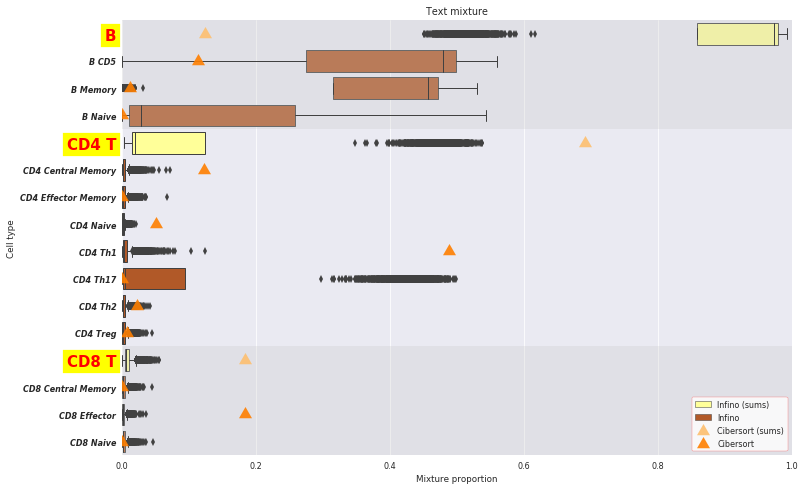

In [67]:
f,ax = plot_single_mixture_results(extract_values_for_mixture_by_id(7),
                                   'Text mixture')
# savefig(f, PLOT_DIR+'fig1b.png', dpi=300)
# savefig(f, PLOT_DIR+'fig1b.pdf', dpi=300)

Also bringing in new plots from `2.1.2.1 MCMC figure plotting`

['B CD5', 'B Memory', 'B Naive', 'B', 'CD4 Central Memory', 'CD4 Effector Memory', 'CD4 Naive', 'CD4 Th1', 'CD4 Th17', 'CD4 Th2', 'CD4 Treg', 'CD4 T', 'CD8 Central Memory', 'CD8 Effector', 'CD8 Naive', 'CD8 T']


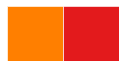

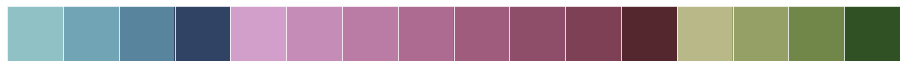

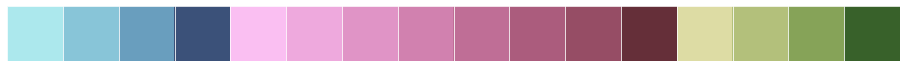

In [68]:
# set up order and colors

paired_colors = sns.color_palette("Paired_r", 12)

# colors for ground truth and cibersort overlays
sns.palplot([paired_colors[4], paired_colors[6]])

hue_order = []
built_palette = []
for r, start in zip(list(rollups), range(0,3)):
    hue_order.extend(rollups[r])
    hue_order.append(r)
    full_pal = sns.cubehelix_palette(len(rollups[r]) + 3,
                                     start=start,
                                     rot=-.25,
                                     light=.7)
    # first #subtypes colors
    built_palette.extend(full_pal[:len(rollups[r])])
    # then a darker color (but not the darkest)
    built_palette.append(full_pal[-2])
hue_order = [h.replace('_', ' ') for h in hue_order]
sns.palplot(built_palette)
print(hue_order)

color_lightening_coeff = 1.2
built_pal_lighter2 = [(np.array(i) * color_lightening_coeff).clip(0,1) for i in built_palette]
sns.palplot(built_pal_lighter2)

In [69]:
def merge_datasets_for_plots(mixID):
    mymix = extract_values_for_mixture_by_id(mixID)
    (key,
     grp,
     #groundtruth_base,
     cib_vals_base,
     #groundtruth_rolledup,
     cib_vals_rolledup
    ) = mymix
    
    grp=grp.copy() # because going to modify
    grp['supertype'] = grp['subset_name'].apply(lambda x: 'CD4 T' if 'CD4' in x else 'CD8 T' if 'CD8' in x else 'B')

    map_row_to_ylevel = {}
    for k in rollups:
        map_row_to_ylevel[k] = 0
        for v,s in zip(rollups[k], range(1, len(rollups[k]) + 1)):
            map_row_to_ylevel[v.replace('_', ' ')] = s

    grp['ylevel'] = grp['subset_name'].apply(lambda x: map_row_to_ylevel[x])

#     # add ground truth
#     gt1 = pd.DataFrame(groundtruth_base).reset_index()
#     gt1.columns = ['rollup', 'estimate']
#     gt1['type'] = 'subset'
#     gt2 = groundtruth_rolledup[['rollup', 'estimate']].copy()
#     gt2['type'] = 'rollup'
#     gt = pd.concat([gt1, gt2])
#     gt['gt'] = gt['estimate']
#     del gt['estimate']

#     merged_grp = pd.merge(grp, gt, left_on='subset_name', right_on='rollup', how='left')

    merged_grp = grp
    
    # add cibersort points
    cb_base = pd.DataFrame(cib_vals_base).reset_index()
    cb_base.columns = ['SubSet', 'estimate']
    cb_base['type'] = 'subset'

    cb_rolledup = pd.DataFrame(cib_vals_rolledup).reset_index()
    cb_rolledup.columns = ['SubSet', 'estimate']
    cb_rolledup['type'] = 'rollup'

    cb = pd.concat([cb_base, cb_rolledup])
    cb.SubSet = cb.SubSet.str.replace('_', ' ') # normalize names

    cb = cb.rename(columns={'estimate': 'cb'})

    merged_grp2 = pd.merge(merged_grp, cb, left_on='subset_name', right_on='SubSet', how='left')

#     # compute infino, cibersort, groundtruth relative to ground truth (i.e. 0 is gt)
#     merged_grp2['estimate_rel_gt'] = merged_grp2['estimate'] - merged_grp2['gt']
#     merged_grp2['cb_rel_gt'] = merged_grp2['cb'] - merged_grp2['gt']
#     merged_grp2['gt_rel_gt'] = 0.0

    # turn ylevel into a categorical variable so that violinplot knows what to do with it
    merged_grp2['ylevel_str'] = merged_grp2['ylevel'].apply(lambda x: chr(65+x))
    merged_grp2['ylevel_str'].unique()
    
    return merged_grp2 # has everything for plots


In [70]:
merge_datasets_for_plots(1).head()

,sample_id,combined_iter_number,subset_name,estimate,type_x,supertype,ylevel,SubSet,cb,type_y,ylevel_str
0,1,0,B CD5,0.327539,subset,B,1,B CD5,0.399919,subset,B
1,1,1,B CD5,0.325144,subset,B,1,B CD5,0.399919,subset,B
2,1,2,B CD5,0.322562,subset,B,1,B CD5,0.399919,subset,B
3,1,3,B CD5,0.309711,subset,B,1,B CD5,0.399919,subset,B
4,1,4,B CD5,0.319754,subset,B,1,B CD5,0.399919,subset,B


In [71]:
def plot_mcmc_areas(merged_dataset, relative_to_groundtruth=False):
    """
    plot MCMC areas, perhaps relative_to_groundtruth if flag enabled
    feed in output of merge_datasets_for_plots(mixID)
    """
    
    # HERE THERE'S NO GT
    assert not relative_to_groundtruth
    
    estimate_var = 'estimate_rel_gt' if relative_to_groundtruth else 'estimate'
    gt_var = 'gt_rel_gt' if relative_to_groundtruth else 'gt'
    cb_var = 'cb_rel_gt' if relative_to_groundtruth else 'cb'
    label_cut_point = 0 if relative_to_groundtruth else .5

    with sns.plotting_context("talk"):
        with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
            g = sns.FacetGrid(merged_dataset,
                              row="ylevel", 
                              hue="subset_name",
                              col="supertype",
                              row_order=reversed(list(range(merged_dataset.ylevel.values.max()+1))),
                              hue_order=hue_order,
                              aspect=15,
                              size=.5,
                              palette=built_palette,
                              sharey=False # important -- they don't share y ranges.
                             )

            ## Draw the densities in a few steps
            # this is the shaded area
            g.map(sns.kdeplot,
                  estimate_var,
                  clip_on=False,
                  shade=True,
                  alpha=.8,
                  lw=2,
                 ) 

            # this is the dividing horizontal line
            g.map(plt.axhline, y=0, lw=2, clip_on=False, ls='dashed')
            
            ### Add label for each facet.

            def label(type_series, estimates, cut_point=.5, **kwargs):
                """
                type_series is a Series that corresponds to this facet. it will have values "subset" or "rollup"
                kwargs is e.g.: {'color': (0.4918017777777778, 0.25275644444444445, 0.3333333333333333), 'label': 'CD4 Treg'}
                use estimates to find median. put rollup label on left/right based on that
                """
                type_of_label = type_series.values[0]
                color = kwargs['color']
                label = kwargs['label']
                estimate_median = estimates.median()
                ax = plt.gca() # map() changes current axis repeatedly
                if type_of_label == 'rollup':
                    plot_on_right = (estimate_median <= cut_point)
                    ax.text(
                            1 if plot_on_right else 0,
                            .2,
                            label + " (sum)", #label,
                            fontweight="bold",
                            color=color, 
                            ha="right" if plot_on_right else "left",
                            va="center", transform=ax.transAxes,
                            fontsize='x-large', #15,
                            bbox=dict(facecolor='yellow', alpha=0.3)
                           )
                else:
                    ax.text(1, .2,
                            label,
                            fontweight="bold",
                            color=color, 
                            ha="right", va="center", transform=ax.transAxes
                           )

            g.map(label, "type_x", estimate_var, cut_point=label_cut_point)
            
            ### Overlay Cibersort and Ground Truth points at the right heights.

            def get_kde_intersection_yval(x0, kde_x, kde_y):
                """
                we want to find y value at which kde line
                (defined by [kde_x, kde_y] point collection)
                intersects x=x0
                (kde_x, kde_y are numpy ndarrays)
                """
                if x0 in kde_x:
                    # the point actually is in the kde point definition!
                    return kde_y[np.where(kde_x == x0)][0]
                elif not (kde_x.min() <= x0 <= kde_x.max()):
                    # out of bounds of the kde
                    return 0
                else:
                    # need to interpolate
                    # find the two x values that most closely encircle x0
                    # then take average of their y values
                    # i.e. linear approximation 
                    diffs = np.abs(kde_x - x0)
                    idxs = np.argsort(diffs) # like argmin, but multiple outputs -- indexes for sorted order
                    argmins = idxs[:2]
                    return np.mean(kde_y[argmins])

            def plot_point(gt, scattercolor, legendlabel, plotline=True, linestyle='solid', linecolor='k', s=100, zorder=10, **kwargs):
                """
                custom function to overlay ground truth and cibersort
                method signature is: *args, **kwargs
                make sure not to have any custom kwargs named "color" or "label"
                those are passed in by default related to facet.. avoid
                """

                # get rid of "label" and "color" that seaborn passes in
                # so we don't pass double kwargs to ax.scatter
                kwargs.pop('label', None) 
                kwargs.pop('color', None) 

                ax = plt.gca()
                # passed in a gt series
                # all values are the same, since we did a left merge
                # (there's only one gt value per facet)
                xval = gt.values[0]
                
                # get y value of kde at this xval
                kde_line = ax.get_lines()[0].get_data()
                ymax = get_kde_intersection_yval(xval, kde_line[0], kde_line[1])
                # plot
                ax.scatter([xval], [ymax],
                           s=s,
                           c=scattercolor,
                           zorder=zorder,
                           clip_on=False, # means not clipped by axis limits (so we see the whole circle)
                           label=legendlabel,
                           **kwargs
                          ) 
                if plotline:
                    ax.vlines(x=xval, ymin=0, ymax=ymax, linewidths=2, colors=linecolor, linestyles=linestyle)
                    # not axvline, because ymin,ymax are in axes coordinates for axvline, not in data coordinates

#             # ground truth
#             g.map(plot_point,
#                   gt_var,
#                   scattercolor=paired_colors[4],
#                   legendlabel='Ground Truth',
#                   linecolor=paired_colors[4],
#                   plotline=(not relative_to_groundtruth),
#                   marker=(5, 1),
#                   alpha=.8,
#                   zorder=50,
#                   s=200,
#                  )
#             if relative_to_groundtruth:
#                 # for this plot, extend ground truth line to ymax
#                 # axvline defaults to y \in [0,1], where that's in axes coordinates (bottom and top of plot)
#                 g.map(lambda *args, **kwargs: plt.gca().axvline(x=0,
#                                                                 c=paired_colors[4],
#                                                                 ls='dashed',
#                                                                 lw=3
#                                                                )
#                      )

            # cibersort 
            g.map(plot_point,
                  cb_var,
                  scattercolor=paired_colors[6],
                  linecolor=paired_colors[6],
                  legendlabel='Cibersort',
                  zorder=10,
                  alpha=.8
                 )
            
            ## Beautify the plot.

            # change x axis ranges
            if relative_to_groundtruth:
                # compute sensible xrange -- round up to nearest .25 (i.e. use math.ceil() not round())
                # we do this manually rather than setting sharex=True because want 0 to be centered (i.e. +/- same amount)
                xrng = np.ceil(max(merged_dataset.estimate_rel_gt.abs().max(),
                                   merged_dataset.cb_rel_gt.abs().max()) * 4) / 4
                g.set(
                    xlim=(-xrng - .02, xrng + .02), # so label shows up
                    xticks=np.arange(-xrng,xrng+.01,.1), # so final tick is included
                 )
            else:
                g.set(xlim=(-0.01, 1.01))

            # change y axis ranges
            g.set(ylim=(0,None)) # seems to do the trick along with sharey=False

            # Disable overlap.
            # TODO: remove this?
            # Some `subplots_adjust` line is necessary. without this, nothing appears
            g.fig.subplots_adjust(hspace=0)

            # Remove axes details that don't play will with overlap
            g.set_titles("")
            #g.set_titles(col_template="{col_name}", row_template="")
            g.set(yticks=[], ylabel='')
            g.despine(bottom=True, left=True)

            # fix x axis
            g.set_xlabels('Mixture proportion relative to ground truth' if relative_to_groundtruth else 'Mixture proportion')

            # resize
            cur_size = g.fig.get_size_inches()
            increase_vertical = 7 #4 # 3
            g.fig.set_size_inches(cur_size[0], cur_size[1] + increase_vertical)

            # legend
            handles, labels = g.fig.gca().get_legend_handles_labels()
            chosen_labels_idx = [
                #labels.index('Ground Truth'),
                labels.index('Cibersort')
                                ]
            legend = g.fig.gca().legend([handles[i] for i in chosen_labels_idx],
                                        [labels[i] for i in chosen_labels_idx],
                                        loc='upper right',
                                        frameon=True,
                                        bbox_to_anchor = (0,-0.1,1,1),
                                        bbox_transform = g.fig.transFigure
                                       )
            # without bbox_to_anchor this gets applied to upper right of the last axis
            frame = legend.get_frame()
            frame.set_edgecolor(built_palette[0])
            frame.set_facecolor('white')

            #g.fig.suptitle("Descriptive title")

            # tighten
            g.fig.tight_layout()
            # then reoverlap
            #g.fig.subplots_adjust(hspace=-.1)

            # done
            return g, g.fig

In [72]:
def plot_violins(merged_dataset):
    """
    violinplot. feed in output of merge_datasets_for_plots(mixID)
    """
    
    with sns.plotting_context("talk"):
        with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
            g = sns.FacetGrid(merged_dataset,
                              row="ylevel", # subset_name
                              hue="subset_name",
                              col="supertype",
                              row_order=reversed(list(range(merged_dataset.ylevel.values.max()+1))),
                              #row_order=hue_order,
                              hue_order=hue_order,
                              aspect=7,
                              size=1,
                              palette=built_pal_lighter2,
                              #sharex=True, # would force all xranges to be same, but we do this manually below
                              sharey=False # important -- they don't share y ranges.
                             )

            g.map_dataframe(sns.violinplot,
                x="estimate",
                y="ylevel_str",
                orient="h",
                #palette="Set3", # color comes in as "color" kwarg per map_dataframe source in axisgrid.py
                dodge=False,
                cut=0,
                bw=.2,
                scale='width',
                saturation=1, # see below, this isn't alpha. this just forces color to be plotted normally
                #alpha=.5, # doesn't do anything
                sharey=False,
                legend=False,
                clip_on=False,
                legend_out=False,
            )

            def addcustompoint(x, y, lbl, c='red', s=100, zorder=10, **kwargs):
                kwargs.pop('color', None)
                kwargs.pop('label', None)
                try: # some axes don't have any values
                    plt.scatter(x=x.values[0],
                                  y=0,
                                  s=s,
                                  c=c,
                                  label=lbl,
                                  zorder=zorder,
                                  clip_on=False,
                                  **kwargs
                                 )
                except:
                    pass

#             g.map(addcustompoint, "gt", "ylevel_str", c=paired_colors[4], lbl='Ground Truth', marker=(5, 1), s=200, zorder=50, alpha=.8)
            g.map(addcustompoint, "cb", "ylevel_str", c=paired_colors[6], lbl='Cibersort', alpha=.8)


            g.map(plt.axhline, y=0, lw=2, clip_on=False, ls='dashed')

            def label(*args, **kwargs):
                """
                args[0] is a Series that corresponds to this facet. it will have values "subset" or "rollup"
                kwargs is e.g.: {'color': (0.4918017777777778, 0.25275644444444445, 0.3333333333333333), 'label': 'CD4 Treg'}
                use estimate (args[1]) to find median. put rollup label on left/right based on that
                """
                #print(args)
                #print(kwargs)
                type_of_label = args[0].values[0]
                color = np.array(kwargs['color'])

                # DARKEN COLOR
                color /= color_lightening_coeff
                color.clip(0,1)

                label = kwargs['label']
                estimate_median = args[1].median()
                ax = plt.gca() # map() changes current axis a ton
                if type_of_label == 'rollup':
                    plot_on_right = (estimate_median <= .5)
                    ax.text(
                            1 if plot_on_right else 0,
                            .2,
                            label + " (sum)", #label,
                            fontweight="bold",
                            color=color, 
                            ha="right" if plot_on_right else "left",
                            va="center", transform=ax.transAxes,
                            fontsize='x-large', #15,
                            bbox=dict(facecolor='yellow', alpha=0.3)
                           )
                else:
                    ax.text(1, .2,
                            label,
                            fontweight="bold",
                            color=color, 
                            ha="right", va="center", transform=ax.transAxes
                           )

            g.map(label, "type_x", "estimate")

            g.set(xlim=(0,1))     

            # Remove axes details that don't play will with overlap
            g.set_titles("")
            #g.set_titles(col_template="{col_name}", row_template="")
            g.set(yticks=[], ylabel='')
            g.despine(bottom=True, left=True)

            # fix x axis
            g.set_xlabels('Mixture proportion')



            # legend
            handles, labels = g.fig.gca().get_legend_handles_labels()
            chosen_labels_idx = [
                #labels.index('Ground Truth'),
                labels.index('Cibersort')
                                ]
            legend = g.fig.gca().legend([handles[i] for i in chosen_labels_idx],
                                        [labels[i] for i in chosen_labels_idx],
                                        loc='upper right',
                                        frameon=True,
                                        bbox_to_anchor = (0,-0.1,1,1),
                                        bbox_transform = g.fig.transFigure
                                       )
            # without bbox_to_anchor this gets applied to upper right of the last axis, which is the CD8 T cell bottommost facet
            frame = legend.get_frame()
            frame.set_edgecolor(built_palette[0])
            frame.set_facecolor('white')

            # tighten
            g.fig.tight_layout()

            return g, g.fig

(<seaborn.axisgrid.FacetGrid at 0x7fe8479360b8>,
 <matplotlib.figure.Figure at 0x7fe8479361d0>)

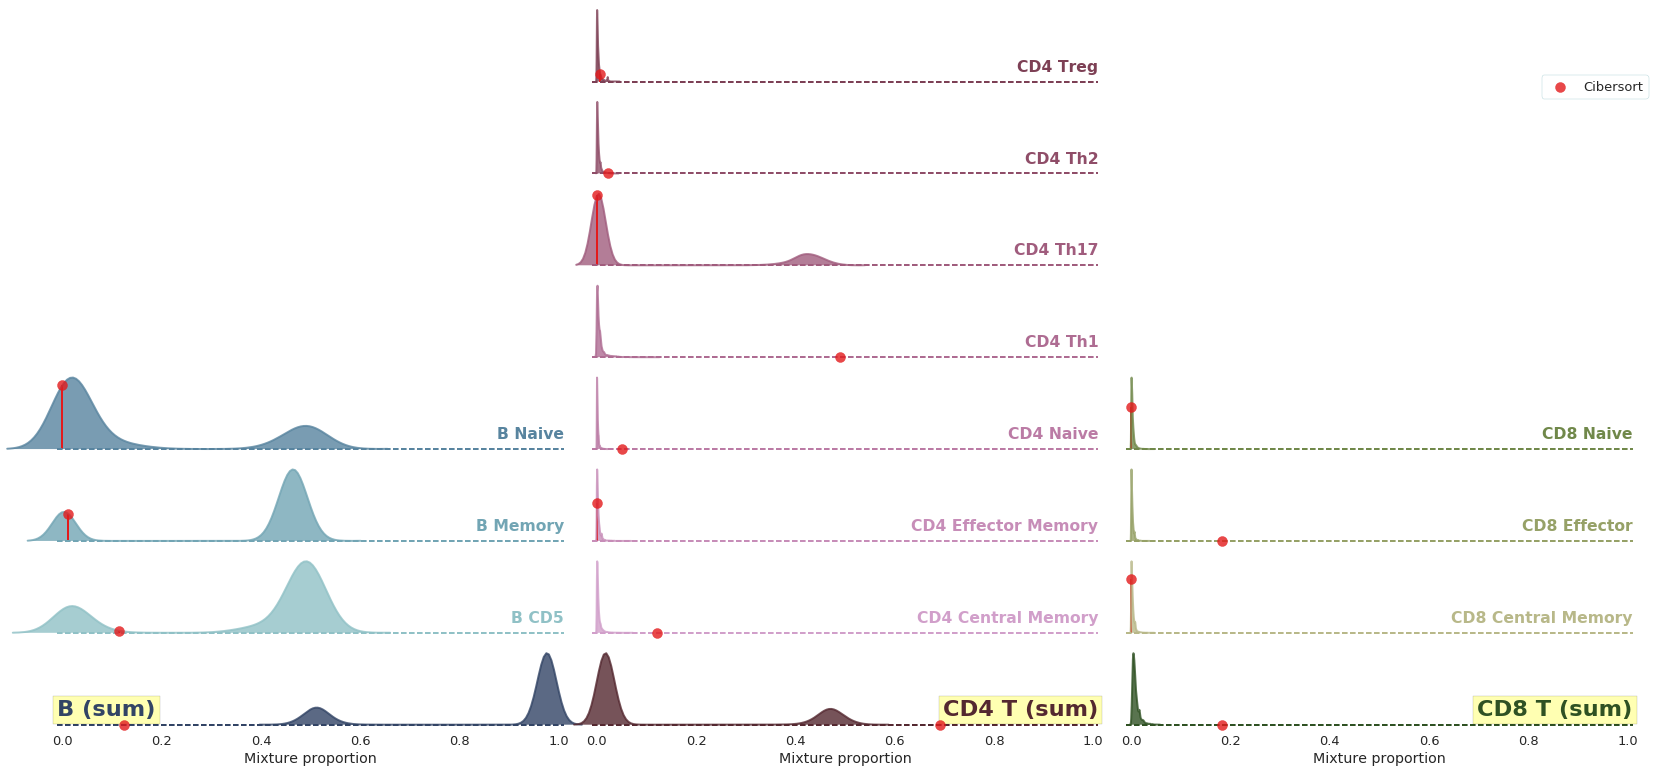

In [73]:
plot_mcmc_areas(merge_datasets_for_plots(7), relative_to_groundtruth=False)

(<seaborn.axisgrid.FacetGrid at 0x7fe841b315c0>,
 <matplotlib.figure.Figure at 0x7fe86ae068d0>)

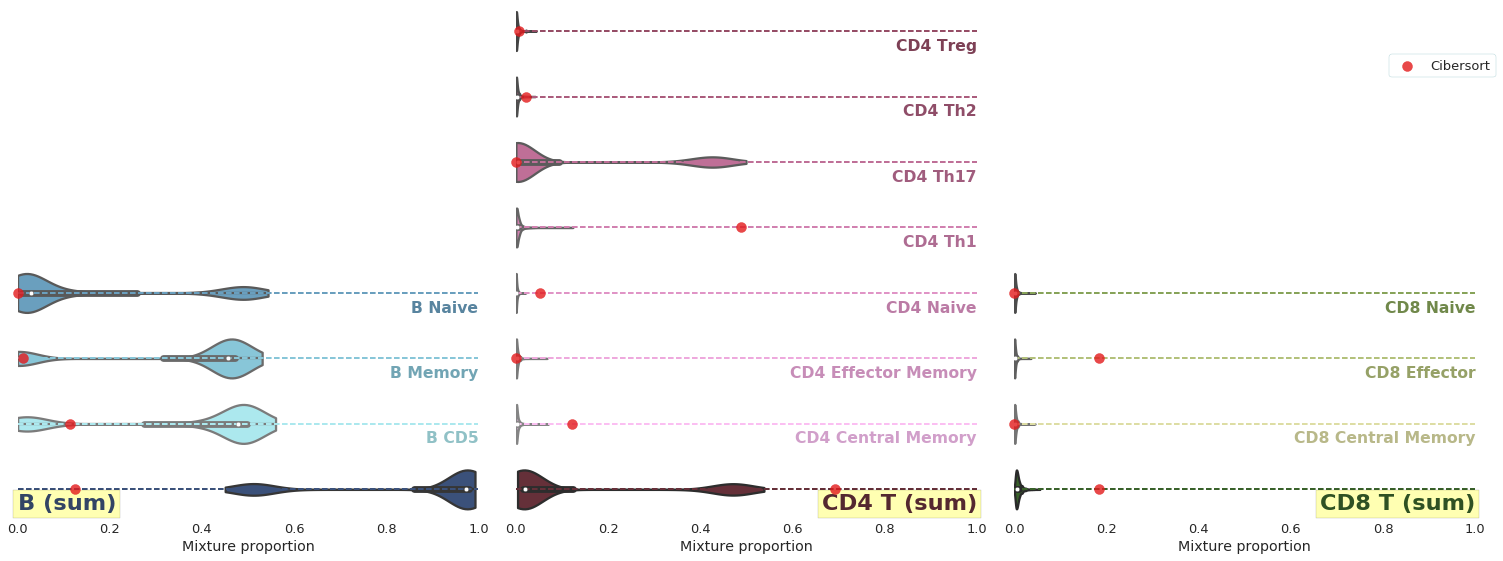

In [74]:
plot_violins(merge_datasets_for_plots(7))

## Make these plots for every mixture.

In [76]:
if make_all_plots:
    for sid in merged_samples.sample_id.unique():
        f,ax = plot_single_mixture_results(extract_values_for_mixture_by_id(sid),
                                       'Sample %d' % sid)
        savefig(f, PLOT_DIR+'sample%d.legacy.pdf' % sid, dpi=300)

        g,f = plot_mcmc_areas(merge_datasets_for_plots(sid), relative_to_groundtruth=False)
        g.savefig(PLOT_DIR+"sample%d.mcmcareas.pdf" % sid, dpi=300)

        g,f = plot_violins(merge_datasets_for_plots(7))
        g.savefig(PLOT_DIR+"sample%d.violins.pdf" % sid, dpi=300)
else:
    print("Deactivated")

Deactivated


# Traceplots 

In [77]:
# # traceplots

# see https://github.com/stan-dev/pystan/blob/develop/pystan/plots.py
# see https://github.com/stan-dev/pystan/blob/develop/pystan/stanfit4model.pyx#L487
# see https://pymc-devs.github.io/pymc3/notebooks/getting_started.html#Posterior-analysis
# see https://github.com/pymc-devs/pymc3/blob/master/pymc3/plots/traceplot.py
from pystan.external.pymc import plots
# actually this imports https://github.com/stan-dev/pystan/blob/develop/pystan/external/pymc/plots.py


all_traces_df3.head()

,iter,trace_id,variable,estimate,sample_id,subset_id,subset_name,combined_iter_number,rollup
1000,0,0,sample2_x.1.1,0.327539,1,1,B_CD5,0,B
1001,1,0,sample2_x.1.1,0.325144,1,1,B_CD5,1,B
1002,2,0,sample2_x.1.1,0.322562,1,1,B_CD5,2,B
1003,3,0,sample2_x.1.1,0.309711,1,1,B_CD5,3,B
1004,4,0,sample2_x.1.1,0.319754,1,1,B_CD5,4,B


In the following traceplots, note that we ensure above that we don't use the index column as x axis, and instead use iter. that way the chains are combined.

(0, 1)

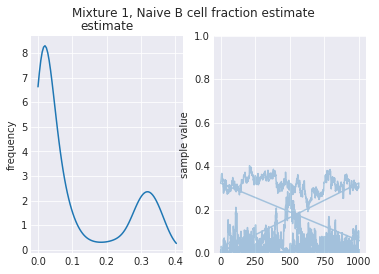

In [78]:
g = plots.traceplot(
    all_traces_df3[(all_traces_df3['sample_id'] == 1)
                   & (all_traces_df3['subset_name'] == 'B_Naive')].set_index(
                       'iter')[['estimate']],
    vars=['estimate'])
g.suptitle('Mixture 1, Naive B cell fraction estimate')
g.gca().set_ylim(0, 1)

(0, 1)

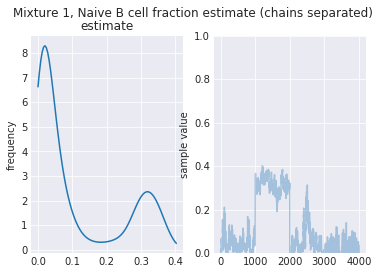

In [79]:
# break out by chain to demonstrate how chains aren't converging
# how: set_index() to combined_iter_number instead of iter

g = plots.traceplot(
    all_traces_df3[(all_traces_df3['sample_id'] == 1)
                   & (all_traces_df3['subset_name'] == 'B_Naive')].set_index(
                       'combined_iter_number')[['estimate']],
    vars=['estimate'])
g.suptitle('Mixture 1, Naive B cell fraction estimate (chains separated)')
g.gca().set_ylim(0, 1)

(0, 1)

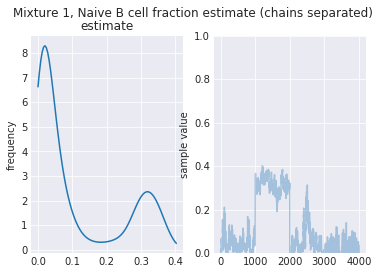

In [80]:
# break out by chain to demonstrate how chains aren't converging
# how: set_index() to combined_iter_number instead of iter

g = plots.traceplot(
    merged_samples[(merged_samples['sample_id'] == 1)
                   & (merged_samples['subset_name'] == 'B Naive')].set_index(
                       'combined_iter_number')[['estimate']],
    vars=['estimate'])
g.suptitle('Mixture 1, Naive B cell fraction estimate (chains separated)')
g.gca().set_ylim(0, 1)

(0, 1)

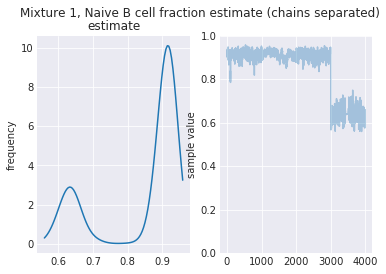

In [81]:
# break out by chain to demonstrate how chains aren't converging
# how: set_index() to combined_iter_number instead of iter

g = plots.traceplot(
    merged_samples[(merged_samples['sample_id'] == 1)
                   & (merged_samples['subset_name'] == 'B')].set_index(
                       'combined_iter_number')[['estimate']],
    vars=['estimate'])
g.suptitle('Mixture 1, Naive B cell fraction estimate (chains separated)')
g.gca().set_ylim(0, 1)

try to put these all together on one plot, for our diagnostics

here's how the function is written in pystan -> pymc -> plots.py

```
def traceplot(trace, vars=None):
    if vars is None:
        vars = trace.varnames

    if isinstance(trace, MultiTrace):
        trace = trace.combined()

    n = len(vars)
    f, ax = subplots(n, 2, squeeze=False)

    for i, v in enumerate(vars):
        d = np.squeeze(trace[v])

        if trace[v].dtype.kind == 'i':
            ax[i, 0].hist(d, bins=sqrt(d.size))
        else:
            kdeplot_op(ax[i, 0], d)
        ax[i, 0].set_title(str(v))
        ax[i, 1].plot(d, alpha=.35)

        ax[i, 0].set_ylabel("frequency")
        ax[i, 1].set_ylabel("sample value")

    return f
```


In [82]:
uniq_subset_names = merged_samples.subset_name.unique().tolist()
uniq_subset_names

['B CD5',
 'B Memory',
 'B Naive',
 'CD4 Central Memory',
 'CD4 Effector Memory',
 'CD4 Naive',
 'CD4 Th1',
 'CD4 Th17',
 'CD4 Th2',
 'CD4 Treg',
 'CD8 Central Memory',
 'CD8 Effector',
 'CD8 Naive',
 'B',
 'CD4 T',
 'CD8 T']

tried to do the below using library, but ended up having to reimplement:

```

# break out by chain to demonstrate how chains aren't converging
# how: set_index() to combined_iter_number instead of iter

def all_traces(merged_samples, sample_id):
    trace_col = {}
    for s in uniq_subset_names:
        trace_col[s] = merged_samples[(merged_samples['sample_id'] == sample_id)
                   & (merged_samples['subset_name'] == s)].set_index(
                       'combined_iter_number')[['estimate']]

g = plots.traceplot(
    all_traces(merged_samples, 1),
    vars=uniq_subset_names #vars=['estimate']
)
#g.suptitle('Mixture 1, Naive B cell fraction estimate (chains separated)')
#g.gca().set_ylim(0, 1)
```

(keeping as documentation here of the attempt, but made into markdown block so that doesn't trip up our script)

In [83]:
col_order, merged_samples.subset_name.unique().tolist()

(['B',
  'B CD5',
  'B Memory',
  'B Naive',
  'CD4 T',
  'CD4 Central Memory',
  'CD4 Effector Memory',
  'CD4 Naive',
  'CD4 Th1',
  'CD4 Th17',
  'CD4 Th2',
  'CD4 Treg',
  'CD8 T',
  'CD8 Central Memory',
  'CD8 Effector',
  'CD8 Naive'],
 ['B CD5',
  'B Memory',
  'B Naive',
  'CD4 Central Memory',
  'CD4 Effector Memory',
  'CD4 Naive',
  'CD4 Th1',
  'CD4 Th17',
  'CD4 Th2',
  'CD4 Treg',
  'CD8 Central Memory',
  'CD8 Effector',
  'CD8 Naive',
  'B',
  'CD4 T',
  'CD8 T'])

In [84]:
# reimplement on our own
# based on https://github.com/stan-dev/pystan/blob/develop/pystan/external/pymc/plots.py

def multi_traceplot(merged_samples, sample_id):
    #vars = merged_samples.subset_name.unique().tolist()
    vars = col_order

    n = len(vars)
    f, ax = plt.subplots(n, 2, squeeze=False,
                        figsize=(15,35))

    for i, v in enumerate(vars):
        d = np.squeeze(merged_samples[(merged_samples['sample_id'] == sample_id)
                   & (merged_samples['subset_name'] == v)].set_index(
                       'combined_iter_number')[['estimate']])

        #if trace[v].dtype.kind == 'i':
        #    ax[i, 0].hist(d, bins=sqrt(d.size))
        #else:
        #    kdeplot_op(ax[i, 0], d)
        plots.kdeplot_op(ax[i,0], d)
        
        ax[i, 0].set_title(str(v))
        ax[i, 1].plot(d, alpha=.35)
        
        ax[i,0].set_xlim(0, 1)
        ax[i,1].set_ylim(0, 1)

        ax[i, 0].set_ylabel("frequency")
        ax[i, 1].set_ylabel("sample value")
    
    #ax[-1, 0].set_ylabel("Frequency")
    #ax[-1, 1].set_ylabel("Sample value")

    return f


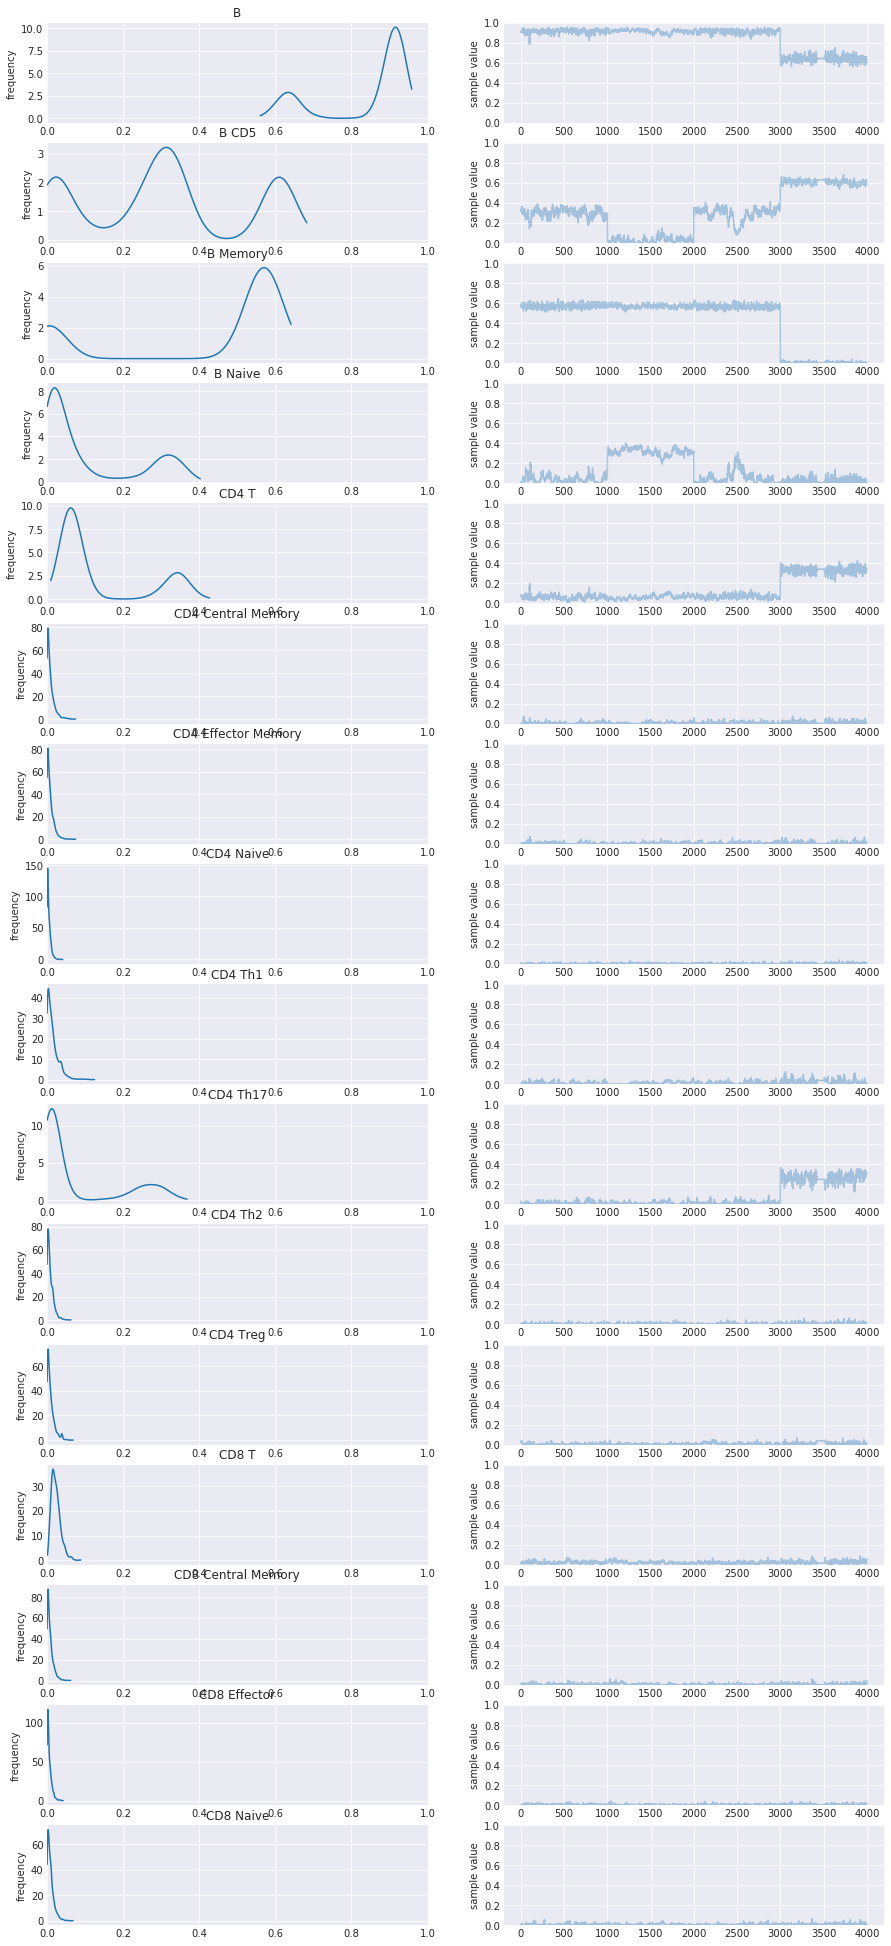

In [85]:
multi_traces_f = multi_traceplot(merged_samples, 1)

In [86]:
if make_all_plots:
    for sid in merged_samples.sample_id.unique():
        multitrace = multi_traceplot(merged_samples, sid)
        savefig(multitrace, PLOT_DIR+'traces.sample_%d.pdf' % sid, dpi=300)
else:
    print("deactivated")

deactivated


Also use this to look at serial correlation!

# correlation matrix

In [87]:
# not Omega_L
omega = stan_summary[stan_summary.name.str.startswith('Omega[')] 
omega.shape

(169, 10)

In [88]:
mean_matrix = omega['Mean'].values.reshape(13, 13)
omega_df = pd.DataFrame(mean_matrix, columns=subset_names).rename(
columns=lambda x: x.replace('_', ' '))
subset_names_cleaner = list(omega_df.columns)
omega_df

,B CD5,B Memory,B Naive,CD4 Central Memory,CD4 Effector Memory,CD4 Naive,CD4 Th1,CD4 Th17,CD4 Th2,CD4 Treg,CD8 Central Memory,CD8 Effector,CD8 Naive
0,1.000000,0.464856,0.791078,0.586455,0.586444,0.554449,0.581681,0.584911,0.551998,0.565867,0.588043,0.580473,0.558395
1,0.464856,1.000000,0.526341,0.369179,0.369303,0.349462,0.371839,0.386018,0.350851,0.355088,0.373900,0.376419,0.344489
2,0.791078,0.526341,1.000000,0.693492,0.694777,0.680039,0.703325,0.686003,0.655864,0.668613,0.688030,0.689297,0.682824
3,0.586455,0.369179,0.693492,1.000000,0.981461,0.955992,0.978947,0.970462,0.958444,0.969999,0.977350,0.964887,0.960306
4,0.586444,0.369303,0.694777,0.981461,1.000000,0.942703,0.976157,0.973248,0.962808,0.961198,0.984239,0.973934,0.946680
5,0.554449,0.349462,0.680039,0.955992,0.942703,1.000000,0.961440,0.951321,0.934978,0.939913,0.954238,0.940899,0.972383
6,0.581681,0.371839,0.703325,0.978947,0.976157,0.961440,1.000000,0.973818,0.947501,0.964512,0.975537,0.969541,0.966933
7,0.584911,0.386018,0.686003,0.970462,0.973248,0.951321,0.973818,1.000000,0.957425,0.964380,0.971297,0.963504,0.954001
8,0.551998,0.350851,0.655864,0.958444,0.962808,0.934978,0.947501,0.957425,1.000000,0.939093,0.963983,0.957170,0.932059
9,0.565867,0.355088,0.668613,0.969999,0.961198,0.939913,0.964512,0.964380,0.939093,1.000000,0.959666,0.945944,0.938945


In [89]:
subset_names_cleaner

['B CD5',
 'B Memory',
 'B Naive',
 'CD4 Central Memory',
 'CD4 Effector Memory',
 'CD4 Naive',
 'CD4 Th1',
 'CD4 Th17',
 'CD4 Th2',
 'CD4 Treg',
 'CD8 Central Memory',
 'CD8 Effector',
 'CD8 Naive']

In [90]:
omega_df.shape, mean_matrix.shape

((13, 13), (13, 13))

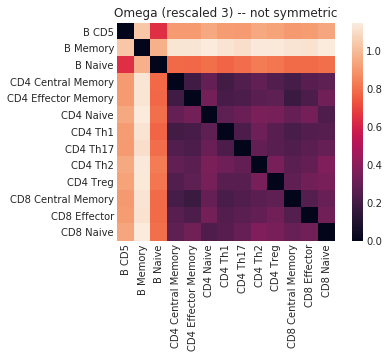

In [91]:
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage
# make into distance matrix as suggested in links above
rescaled = np.sqrt(2*(1-mean_matrix))
#rescaled /= 2 # my own
g = sns.heatmap(rescaled, square=True,
                xticklabels=subset_names_cleaner,
                yticklabels=subset_names_cleaner
               )
plt.title('Omega (rescaled 3) -- not symmetric')

In [92]:
pdist = scipy.spatial.distance.squareform(rescaled)
pdist

array([ 1.03454724,  0.64640854,  0.90944489,  0.90945698,  0.94398199,
        0.91467918,  0.91114104,  0.94657488,  0.93180792,  0.90769709,
        0.91599891,  0.93979253,  0.97330263,  1.12322838,  1.12311798,
        1.14064718,  1.12085771,  1.10813537,  1.1394288 ,  1.13570419,
        1.11901743,  1.11676408,  1.14499869,  0.78295338,  0.78131044,
        0.79995125,  0.77029215,  0.79246072,  0.8296216 ,  0.81410933,
        0.78989873,  0.78829309,  0.79646218,  0.19255649,  0.29667491,
        0.20519747,  0.24305555,  0.28829152,  0.24495306,  0.21283797,
        0.26500189,  0.28175876,  0.33851736,  0.21837124,  0.23130932,
        0.2727343 ,  0.27857495,  0.17754436,  0.22832433,  0.3265578 ,
        0.27770488,  0.31202244,  0.36061614,  0.34666122,  0.30252934,
        0.34380518,  0.23501915,  0.22883182,  0.32403395,  0.26641321,
        0.22119222,  0.24681572,  0.25716532,  0.29180473,  0.26690822,
        0.23959549,  0.27017032,  0.30331172,  0.34901862,  0.26

In [93]:
# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
links = linkage(pdist, 'ward') # row i is which clusters were merged in i-th iteration, their distance, and their sample count
print(links)
from scipy.cluster.hierarchy import cophenet
c, _ = cophenet(links, pdist)
c # want close to 1: means actual pairwise distances well preserved by hierarchical clustering

[[  4.          10.           0.17754436   2.        ]
 [  3.           6.           0.20519747   2.        ]
 [ 13.          14.           0.22952342   4.        ]
 [  5.          12.           0.23501915   2.        ]
 [  7.          15.           0.2523454    5.        ]
 [ 11.          17.           0.27377387   6.        ]
 [  9.          18.           0.30989968   7.        ]
 [  8.          19.           0.33416442   8.        ]
 [ 16.          20.           0.43519995  10.        ]
 [  0.           2.           0.64640854   2.        ]
 [  1.          22.           1.09808439   3.        ]
 [ 21.          23.           1.68024098  13.        ]]


0.95096143383965259

In [94]:
str(c)

'0.95096143384'

In [95]:
with open(PLOT_DIR + 'cophenet.txt', 'w') as w:
    w.write(str(c))

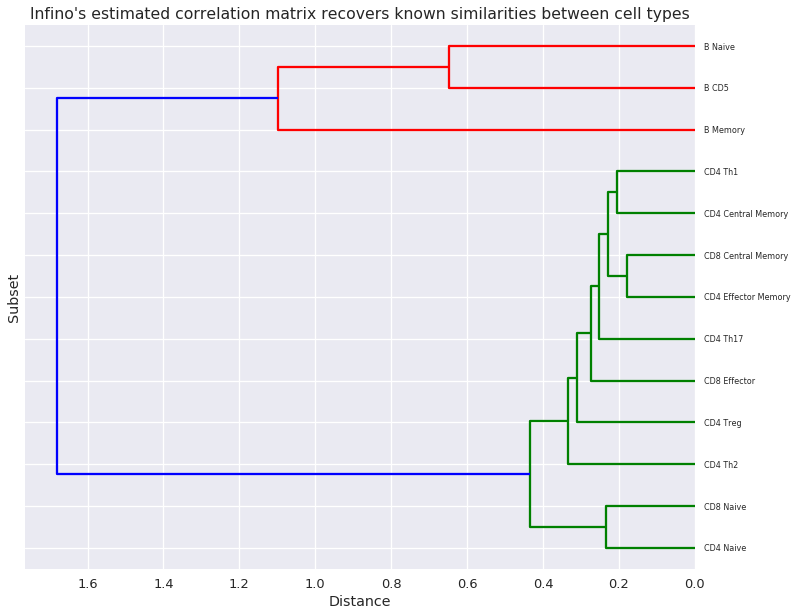

In [96]:

# plt.figure(figsize=(25, 10))
# plt.xlabel('sample index')
# plt.ylabel('distance')
# dendrogram(
#     links,
#     leaf_rotation=90.,  # rotates the x axis labels
#     leaf_font_size=8.,  # font size for the x axis labels
#     labels=colnames_filtered
# )

with sns.plotting_context('talk'):
    f = plt.figure(figsize=(12, 10))
    dendrogram(
        links,
        #leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
        labels=subset_names_cleaner,
        orientation='left'
    )
    plt.xlabel('Distance')
    plt.ylabel('Subset')


    #plt.title('Hierarchical clustering dendrogram from correlation matrix')
    #plt.title("Model's estimated correlation matrix recovers known biological similarities between cell types")
    plt.title("Infino's estimated correlation matrix recovers known similarities between cell types")
    savefig(f, PLOT_DIR+'dendrogram.png', dpi=300)
    savefig(f, PLOT_DIR+'dendrogram.pdf', dpi=300)


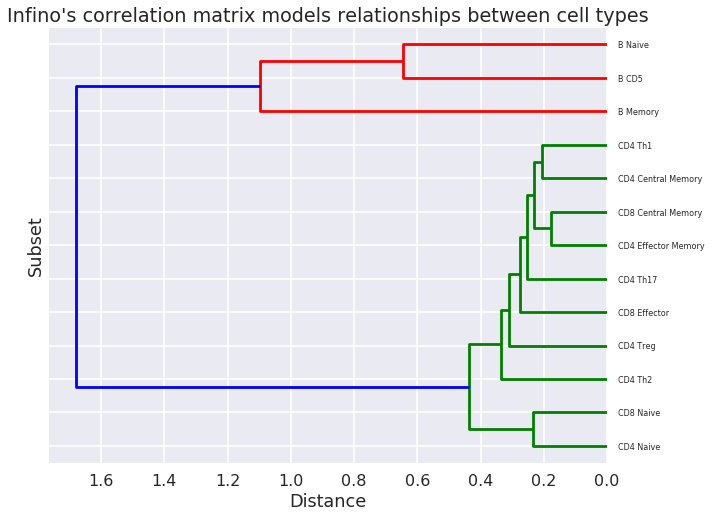

In [97]:
# portrait version


# plt.figure(figsize=(25, 10))
# plt.xlabel('sample index')
# plt.ylabel('distance')
# dendrogram(
#     links,
#     leaf_rotation=90.,  # rotates the x axis labels
#     leaf_font_size=8.,  # font size for the x axis labels
#     labels=colnames_filtered
# )

with sns.plotting_context('poster'):
    f = plt.figure(figsize=(10, 8))
    dendrogram(
        links,
        #leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
        labels=subset_names_cleaner,
        orientation='left'
    )
    plt.xlabel('Distance')
    plt.ylabel('Subset')


    #plt.title('Hierarchical clustering dendrogram from correlation matrix')
    #plt.title("Model's estimated correlation matrix recovers known biological similarities between cell types")
    plt.title("Infino's correlation matrix models relationships between cell types")


Flip from Distance to Similarity:

[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0, 1.2000000000000002, 1.4000000000000001, 1.6, 1.8]
<class 'float'>


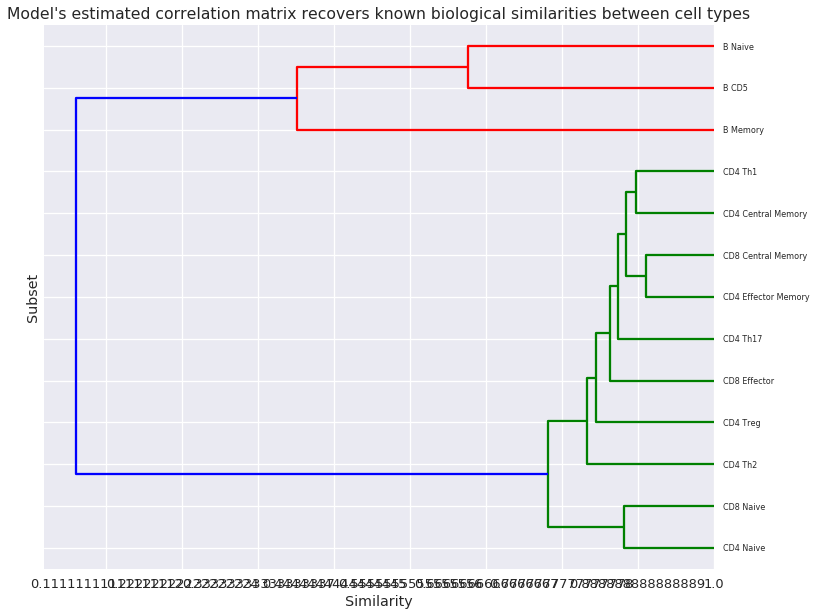

In [98]:
# similarity version

with sns.plotting_context('talk'):
    f = plt.figure(figsize=(12, 10))
    dendrogram(
        links,
        #leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
        labels=subset_names_cleaner,
        orientation='left'
    )
    #plt.xlabel('Distance')
    plt.ylabel('Subset')


    #plt.title('Hierarchical clustering dendrogram from correlation matrix')
    plt.title("Model's estimated correlation matrix recovers known biological similarities between cell types")
    
    #plt.gca().invert_xaxis()
    ax = plt.gca()
#     lbls = plt.gca().get_xticklabels()
#     labels = [t.get_text() for t in plt.gca().get_xticklabels()]
    #labelsrev = list(reversed(labels))
    #ax.set_xticklabels(labelsrev)
    labels = ax.get_xticks().tolist()
    print(labels)
    print(type(labels[0]))
    
    # normalize
    labels_normed = [c / labels[-1] for c in labels]
    
    labelsrev = list(reversed(labels_normed))
    ax.set_xticklabels(labelsrev)
    
    plt.xlabel('Similarity')



Not sure if this is as interpretable. Distance between two items is easy. But how do you subtract similarities?

In [99]:
# pickle out the omega plotting info
pickle.dump([omega_df, rescaled, pdist, links, c], open(PLOT_DIR+"plot_omega_dendrogram.pkl", 'wb'))

# Percentiles

where does cibersort value fall in the mcmc density?

Eliza's code from 2.1.3:

```
infino_percentiles = []

for sample_id in range(1, len(example_result)+1):
    for subset_type in col_order:
        subset_samples = np.array(merged_samples[(merged_samples['subset_name'] == subset_type) &
                                        (merged_samples['sample_id'] == sample_id)]['estimate'])

        # Grab the GT values for the fruit rollups
        if subset_type in rollups.keys():
            try:
                
                gt_value = rollup_groundtruth[(rollup_groundtruth['mixID'] == (sample_id-1)) &
                              (rollup_groundtruth['rollup'] == subset_type)]['estimate'].values[0]   
            except Exception as e:
                import pdb; pdb.set_trace()
                print(e)
                print(subset_type)
                print(rollup_groundtruth[(rollup_groundtruth['mixID'] == sample_id) &
                              (rollup_groundtruth['rollup'] == subset_type)]['estimate'])
        else: # Grab the GT values for the subsets
            gt_value = cleaner_gt.ix[sample_id, subset_type]
        
        # Now calculate percentile of gt_value in subset_samples
        pctile = percentileofscore(a=subset_samples, score=gt_value, kind='weak')
        
        
        infino_percentiles.append({'sample_id':sample_id, 
         'subset_type': subset_type, 
         'tv_percentile': pctile})
infino_percentiles_df = pd.DataFrame(infino_percentiles)
```

just gonna refactor slightly for cibersort

We're going to merge cibersort subset and rollup values into our traces df, much like how we did it in `merge_datasets_for_plots` for one sample at a time, just now vectorized.

In [142]:
merged_samples.head()

,sample_id,combined_iter_number,subset_name,estimate,type
1000,1,0,B CD5,0.327539,subset
1001,1,1,B CD5,0.325144,subset
1002,1,2,B CD5,0.322562,subset
1003,1,3,B CD5,0.309711,subset
1004,1,4,B CD5,0.319754,subset


In [152]:
cibersort_results.head()

,Column,B_CD5,B_Memory,B_Naive,CD4_Central_Memory,CD4_Effector_Memory,CD4_Naive,CD4_Th1,CD4_Th17,CD4_Th2,...,P-value,Pearson Correlation,RMSE,cohort,metric,processing,data_col,cohort_sample_id,incut_sample_id,cutname
0,0,0.399919,0.037487,0.000000,0.110549,0.000000,0.026814,0.067909,0.051771,0.000000,...,0.16,0.175809,1.083791,newbladder,counts,raw,est_counts,1,1,cut1
1,1,0.209169,0.087047,0.000000,0.000000,0.000000,0.000000,0.237297,0.095511,0.000000,...,0.06,0.240786,1.031246,newbladder,counts,raw,est_counts,2,2,cut1
2,2,0.185785,0.074348,0.000000,0.248489,0.000000,0.123715,0.000000,0.000000,0.000000,...,0.26,0.088591,1.129215,newbladder,counts,raw,est_counts,3,3,cut1
3,3,0.223025,0.024229,0.000000,0.135234,0.347997,0.027124,0.000000,0.000000,0.042386,...,0.21,0.120219,1.101249,newbladder,counts,raw,est_counts,4,4,cut1
4,4,0.000000,0.000000,0.120626,0.000000,0.000000,0.000000,0.481722,0.100051,0.000331,...,0.14,0.190251,1.070435,newbladder,counts,raw,est_counts,5,5,cut1


In [223]:
cib_results_1 = pd.melt(
    cibersort_results,
    id_vars=[
        'incut_sample_id', 'cohort', 'metric', 'processing', 'data_col',
        'cutname', 'cohort_sample_id'
    ],
    value_vars=colnames.tolist(), var_name='SubSet', value_name='cb'
)
cib_results_1['type'] = 'subset'
cib_results_1['supertype'] = cib_results_1['SubSet'].apply(lambda x: 'CD4 T' if 'CD4' in x else 'CD8 T' if 'CD8' in x else 'B')
cib_results_1.head()

,incut_sample_id,cohort,metric,processing,data_col,cutname,cohort_sample_id,SubSet,cb,type,supertype
0,1,newbladder,counts,raw,est_counts,cut1,1,B_CD5,0.399919,subset,B
1,2,newbladder,counts,raw,est_counts,cut1,2,B_CD5,0.209169,subset,B
2,3,newbladder,counts,raw,est_counts,cut1,3,B_CD5,0.185785,subset,B
3,4,newbladder,counts,raw,est_counts,cut1,4,B_CD5,0.223025,subset,B
4,5,newbladder,counts,raw,est_counts,cut1,5,B_CD5,0.000000,subset,B


In [224]:
rollupsums_df.head()

,B,CD4 T,CD8 T
0,0.437406,0.359439,0.203155
1,0.296216,0.496703,0.207081
2,0.260133,0.421284,0.318583
3,0.247254,0.552742,0.200005
4,0.120626,0.620227,0.259147


In [225]:
cib_results_2 = rollupsums_df.copy()
cib_results_2['incut_sample_id'] = cib_results_2.index + 1
cib_results_2.head()

,B,CD4 T,CD8 T,incut_sample_id
0,0.437406,0.359439,0.203155,1
1,0.296216,0.496703,0.207081,2
2,0.260133,0.421284,0.318583,3
3,0.247254,0.552742,0.200005,4
4,0.120626,0.620227,0.259147,5


In [227]:
cib_results_3 = pd.melt(cib_results_2, id_vars=['incut_sample_id'], var_name='SubSet', value_name='cb')
cib_results_3['type'] = 'rollup'
cib_results_3.head()

,incut_sample_id,SubSet,cb,type
0,1,B,0.437406,rollup
1,2,B,0.296216,rollup
2,3,B,0.260133,rollup
3,4,B,0.247254,rollup
4,5,B,0.120626,rollup


In [242]:
cib_results_all_melted = pd.concat([cib_results_1, cib_results_3])
assert cib_results_all_melted.shape[0] == cib_results_1.shape[0] + cib_results_3.shape[0]

In [243]:
cib_results_all_melted['SubSet'] = cib_results_all_melted['SubSet'].str.replace('_', ' ')

In [244]:
cib_results_all_melted

,SubSet,cb,cohort,cohort_sample_id,cutname,data_col,incut_sample_id,metric,processing,supertype,type
0,B CD5,0.399919,newbladder,1.0,cut1,est_counts,1,counts,raw,B,subset
1,B CD5,0.209169,newbladder,2.0,cut1,est_counts,2,counts,raw,B,subset
2,B CD5,0.185785,newbladder,3.0,cut1,est_counts,3,counts,raw,B,subset
3,B CD5,0.223025,newbladder,4.0,cut1,est_counts,4,counts,raw,B,subset
4,B CD5,0.000000,newbladder,5.0,cut1,est_counts,5,counts,raw,B,subset
5,B CD5,0.292927,newbladder,6.0,cut1,est_counts,6,counts,raw,B,subset
6,B CD5,0.113036,newbladder,7.0,cut1,est_counts,7,counts,raw,B,subset
7,B CD5,0.096252,newbladder,8.0,cut1,est_counts,8,counts,raw,B,subset
8,B CD5,0.369072,newbladder,9.0,cut1,est_counts,9,counts,raw,B,subset
9,B CD5,0.441408,newbladder,10.0,cut1,est_counts,10,counts,raw,B,subset


In [245]:
samples_infino_and_cib = pd.merge(
    merged_samples,
    cib_results_all_melted,
    left_on=['subset_name', 'sample_id'],
    right_on=['SubSet', 'incut_sample_id'],
    how='left')
samples_infino_and_cib.head()

,sample_id,combined_iter_number,subset_name,estimate,type_x,SubSet,cb,cohort,cohort_sample_id,cutname,data_col,incut_sample_id,metric,processing,supertype,type_y
0,1,0,B CD5,0.327539,subset,B CD5,0.399919,newbladder,1.0,cut1,est_counts,1,counts,raw,B,subset
1,1,1,B CD5,0.325144,subset,B CD5,0.399919,newbladder,1.0,cut1,est_counts,1,counts,raw,B,subset
2,1,2,B CD5,0.322562,subset,B CD5,0.399919,newbladder,1.0,cut1,est_counts,1,counts,raw,B,subset
3,1,3,B CD5,0.309711,subset,B CD5,0.399919,newbladder,1.0,cut1,est_counts,1,counts,raw,B,subset
4,1,4,B CD5,0.319754,subset,B CD5,0.399919,newbladder,1.0,cut1,est_counts,1,counts,raw,B,subset


In [246]:
assert not any(pd.isnull(samples_infino_and_cib['cb']))

In [247]:
from scipy.stats import percentileofscore

percentiles_df = samples_infino_and_cib.groupby(['incut_sample_id', 'subset_name'])\
.apply(lambda grp: percentileofscore(a=grp['estimate'], score=grp['cb'].iloc[0], kind='weak')).reset_index()

percentiles_df.head()

,incut_sample_id,subset_name,0
0,1,B,0.000
1,1,B CD5,74.950
2,1,B Memory,24.975
3,1,B Naive,0.000
4,1,CD4 Central Memory,100.000


In [248]:
percentiles_df.rename(columns={0: 'cb_percentile'}, inplace=True)

In [249]:
percentiles_df.head()

,incut_sample_id,subset_name,cb_percentile
0,1,B,0.000
1,1,B CD5,74.950
2,1,B Memory,24.975
3,1,B Naive,0.000
4,1,CD4 Central Memory,100.000


briefly validate

In [250]:
test_one_bmemory = percentileofscore(a=merged_samples[(merged_samples['subset_name'] == 'B Memory') &
                                        (merged_samples['sample_id'] == 1)]['estimate'].values,
                 score=cibersort_results.iloc[0]['B_Memory'],kind='weak')
print(test_one_bmemory)
print(percentiles_df[(percentiles_df['incut_sample_id'] == 1) & (percentiles_df['subset_name'] == 'B Memory')].cb_percentile.values[0])
assert test_one_bmemory == percentiles_df[(percentiles_df['incut_sample_id'] == 1) & (percentiles_df['subset_name'] == 'B Memory')].cb_percentile.values[0]

24.975
24.975


In [251]:
testsampleid = 5
test_one_bmemory = percentileofscore(a=merged_samples[(merged_samples['subset_name'] == 'B CD5') &
                                        (merged_samples['sample_id'] == testsampleid)]['estimate'].values,
                 score=cibersort_results.iloc[testsampleid - 1]['B_CD5'],kind='weak')
print(test_one_bmemory)
print(percentiles_df[(percentiles_df['incut_sample_id'] == testsampleid) & (percentiles_df['subset_name'] == 'B CD5')].cb_percentile.values[0])
assert test_one_bmemory == percentiles_df[(percentiles_df['incut_sample_id'] == testsampleid) & (percentiles_df['subset_name'] == 'B CD5')].cb_percentile.values[0]

0.0
0.0


In [252]:
testsampleid = 5
test_one_bmemory = percentileofscore(a=merged_samples[(merged_samples['subset_name'] == 'B Naive') &
                                        (merged_samples['sample_id'] == testsampleid)]['estimate'].values,
                 score=cibersort_results.iloc[testsampleid - 1]['B_Naive'],kind='weak')
print(test_one_bmemory)
print(percentiles_df[(percentiles_df['incut_sample_id'] == testsampleid) & (percentiles_df['subset_name'] == 'B Naive')].cb_percentile.values[0])
assert test_one_bmemory == percentiles_df[(percentiles_df['incut_sample_id'] == testsampleid) & (percentiles_df['subset_name'] == 'B Naive')].cb_percentile.values[0]

100.0
100.0


# Output summary csv

In [253]:
merged_samples.head()

,sample_id,combined_iter_number,subset_name,estimate,type
1000,1,0,B CD5,0.327539,subset
1001,1,1,B CD5,0.325144,subset
1002,1,2,B CD5,0.322562,subset
1003,1,3,B CD5,0.309711,subset
1004,1,4,B CD5,0.319754,subset


In [254]:
cibersort_results.head()

,Column,B_CD5,B_Memory,B_Naive,CD4_Central_Memory,CD4_Effector_Memory,CD4_Naive,CD4_Th1,CD4_Th17,CD4_Th2,...,P-value,Pearson Correlation,RMSE,cohort,metric,processing,data_col,cohort_sample_id,incut_sample_id,cutname
0,0,0.399919,0.037487,0.000000,0.110549,0.000000,0.026814,0.067909,0.051771,0.000000,...,0.16,0.175809,1.083791,newbladder,counts,raw,est_counts,1,1,cut1
1,1,0.209169,0.087047,0.000000,0.000000,0.000000,0.000000,0.237297,0.095511,0.000000,...,0.06,0.240786,1.031246,newbladder,counts,raw,est_counts,2,2,cut1
2,2,0.185785,0.074348,0.000000,0.248489,0.000000,0.123715,0.000000,0.000000,0.000000,...,0.26,0.088591,1.129215,newbladder,counts,raw,est_counts,3,3,cut1
3,3,0.223025,0.024229,0.000000,0.135234,0.347997,0.027124,0.000000,0.000000,0.042386,...,0.21,0.120219,1.101249,newbladder,counts,raw,est_counts,4,4,cut1
4,4,0.000000,0.000000,0.120626,0.000000,0.000000,0.000000,0.481722,0.100051,0.000331,...,0.14,0.190251,1.070435,newbladder,counts,raw,est_counts,5,5,cut1


In [255]:
rollupsums_df.head()

,B,CD4 T,CD8 T
0,0.437406,0.359439,0.203155
1,0.296216,0.496703,0.207081
2,0.260133,0.421284,0.318583
3,0.247254,0.552742,0.200005
4,0.120626,0.620227,0.259147


In [256]:
percentiles_df.head()

,incut_sample_id,subset_name,cb_percentile
0,1,B,0.000
1,1,B CD5,74.950
2,1,B Memory,24.975
3,1,B Naive,0.000
4,1,CD4 Central Memory,100.000


In [258]:
summarize_mcmc = merged_samples.groupby(['sample_id', 'subset_name', 'type'])\
['estimate'].agg({'mean', 'std', 'median'}).reset_index()\
.rename(columns={'std': 'infino_std', 'mean': 'infino_mean', 'median': 'infino_median'})
print(summarize_mcmc.shape)
summarize_mcmc.head()

(416, 6)


,sample_id,subset_name,type,infino_std,infino_median,infino_mean
0,1,B,rollup,0.122462,0.907619,0.843722
1,1,B CD5,subset,0.210730,0.306360,0.306496
2,1,B Memory,subset,0.244955,0.561552,0.429172
3,1,B Naive,subset,0.127416,0.040484,0.108054
4,1,CD4 Central Memory,subset,0.009497,0.005889,0.008956


In [264]:
summarize_mcmc2 = pd.merge(summarize_mcmc, percentiles_df, left_on=['sample_id', 'subset_name'], right_on=['incut_sample_id', 'subset_name'], how='inner')
assert summarize_mcmc2.shape[0] == summarize_mcmc.shape[0] == percentiles_df.shape[0]
summarize_mcmc2.head()

,sample_id,subset_name,type,infino_std,infino_median,infino_mean,incut_sample_id,cb_percentile
0,1,B,rollup,0.122462,0.907619,0.843722,1,0.000
1,1,B CD5,subset,0.210730,0.306360,0.306496,1,74.950
2,1,B Memory,subset,0.244955,0.561552,0.429172,1,24.975
3,1,B Naive,subset,0.127416,0.040484,0.108054,1,0.000
4,1,CD4 Central Memory,subset,0.009497,0.005889,0.008956,1,100.000


In [265]:
assert cibersort_results.shape[0] == rollupsums_df.shape[0]

In [266]:
cibersort_concat = pd.concat([cibersort_results, rollupsums_df], axis=1)
assert cibersort_concat.shape[0] == cibersort_results.shape[0] == rollupsums_df.shape[0]
cibersort_concat.head()

,Column,B_CD5,B_Memory,B_Naive,CD4_Central_Memory,CD4_Effector_Memory,CD4_Naive,CD4_Th1,CD4_Th17,CD4_Th2,...,cohort,metric,processing,data_col,cohort_sample_id,incut_sample_id,cutname,B,CD4 T,CD8 T
0,0,0.399919,0.037487,0.000000,0.110549,0.000000,0.026814,0.067909,0.051771,0.000000,...,newbladder,counts,raw,est_counts,1,1,cut1,0.437406,0.359439,0.203155
1,1,0.209169,0.087047,0.000000,0.000000,0.000000,0.000000,0.237297,0.095511,0.000000,...,newbladder,counts,raw,est_counts,2,2,cut1,0.296216,0.496703,0.207081
2,2,0.185785,0.074348,0.000000,0.248489,0.000000,0.123715,0.000000,0.000000,0.000000,...,newbladder,counts,raw,est_counts,3,3,cut1,0.260133,0.421284,0.318583
3,3,0.223025,0.024229,0.000000,0.135234,0.347997,0.027124,0.000000,0.000000,0.042386,...,newbladder,counts,raw,est_counts,4,4,cut1,0.247254,0.552742,0.200005
4,4,0.000000,0.000000,0.120626,0.000000,0.000000,0.000000,0.481722,0.100051,0.000331,...,newbladder,counts,raw,est_counts,5,5,cut1,0.120626,0.620227,0.259147


In [268]:
# put in helper variables
summarize_mcmc2_with_helpers = pd.merge(
    summarize_mcmc2,
    cibersort_concat[[
        'cohort', 'metric', 'processing', 'data_col', 'cutname', 'cohort_sample_id', 'incut_sample_id'
    ]],
    left_on='sample_id',
    right_on='incut_sample_id',
    how='inner')
assert summarize_mcmc2_with_helpers.shape[0] == summarize_mcmc2.shape[0]  # didn't lose anything
summarize_mcmc2_with_helpers.head()


,sample_id,subset_name,type,infino_std,infino_median,infino_mean,incut_sample_id_x,cb_percentile,cohort,metric,processing,data_col,cutname,cohort_sample_id,incut_sample_id_y
0,1,B,rollup,0.122462,0.907619,0.843722,1,0.000,newbladder,counts,raw,est_counts,cut1,1,1
1,1,B CD5,subset,0.210730,0.306360,0.306496,1,74.950,newbladder,counts,raw,est_counts,cut1,1,1
2,1,B Memory,subset,0.244955,0.561552,0.429172,1,24.975,newbladder,counts,raw,est_counts,cut1,1,1
3,1,B Naive,subset,0.127416,0.040484,0.108054,1,0.000,newbladder,counts,raw,est_counts,cut1,1,1
4,1,CD4 Central Memory,subset,0.009497,0.005889,0.008956,1,100.000,newbladder,counts,raw,est_counts,cut1,1,1


In [276]:
assert not summarize_mcmc2_with_helpers.isnull().values.any()

In [279]:
# join in raw cibersort value
all_cib_cols = list(colnames) + list(rollupsums_df.columns)
all_cib_cols

['B_CD5',
 'B_Memory',
 'B_Naive',
 'CD4_Central_Memory',
 'CD4_Effector_Memory',
 'CD4_Naive',
 'CD4_Th1',
 'CD4_Th17',
 'CD4_Th2',
 'CD4_Treg',
 'CD8_Central_Memory',
 'CD8_Effector',
 'CD8_Naive',
 'B',
 'CD4 T',
 'CD8 T']

In [281]:
all_cibs_melted = pd.melt(cibersort_concat, id_vars=['incut_sample_id'], value_vars=all_cib_cols, var_name='subset_name', value_name='cb_estimate')
all_cibs_melted.subset_name = all_cibs_melted.subset_name.str.replace('_', ' ')
all_cibs_melted.head()

,incut_sample_id,subset_name,cb_estimate
0,1,B CD5,0.399919
1,2,B CD5,0.209169
2,3,B CD5,0.185785
3,4,B CD5,0.223025
4,5,B CD5,0.000000


In [282]:
summarize_mcmc3_with_helpers = pd.merge(summarize_mcmc2_with_helpers, all_cibs_melted,
         left_on=['subset_name', 'incut_sample_id_x'],
         right_on=['subset_name', 'incut_sample_id'],
         how='inner'
        )
assert summarize_mcmc3_with_helpers.shape[0] == summarize_mcmc2_with_helpers.shape[0]
assert not summarize_mcmc3_with_helpers.isnull().values.any()

In [283]:
summarize_mcmc3_with_helpers.head()

,sample_id,subset_name,type,infino_std,infino_median,infino_mean,incut_sample_id_x,cb_percentile,cohort,metric,processing,data_col,cutname,cohort_sample_id,incut_sample_id_y,incut_sample_id,cb_estimate
0,1,B,rollup,0.122462,0.907619,0.843722,1,0.000,newbladder,counts,raw,est_counts,cut1,1,1,1,0.437406
1,1,B CD5,subset,0.210730,0.306360,0.306496,1,74.950,newbladder,counts,raw,est_counts,cut1,1,1,1,0.399919
2,1,B Memory,subset,0.244955,0.561552,0.429172,1,24.975,newbladder,counts,raw,est_counts,cut1,1,1,1,0.037487
3,1,B Naive,subset,0.127416,0.040484,0.108054,1,0.000,newbladder,counts,raw,est_counts,cut1,1,1,1,0.000000
4,1,CD4 Central Memory,subset,0.009497,0.005889,0.008956,1,100.000,newbladder,counts,raw,est_counts,cut1,1,1,1,0.110549


In [285]:
assert all(summarize_mcmc3_with_helpers['incut_sample_id_x'] == summarize_mcmc3_with_helpers['incut_sample_id_y'])
assert all(summarize_mcmc3_with_helpers['incut_sample_id_y'] == summarize_mcmc3_with_helpers['incut_sample_id'])

In [287]:
summarize_mcmc3_with_helpers.drop(['incut_sample_id_x', 'incut_sample_id_y'], axis=1, inplace=True)

In [319]:
# ADD R_hats

rhats_df = stan_summary[stan_summary.name.str.startswith('sample2_x')][['name','R_hat']]
rhats_df.head()
rhats_df = pd.concat([rhats_df, rhats_df['name'].str.extract('sample2_x\[(?P<sample_id>\d+),(?P<subset_id>\d+)\]').astype(int)], axis=1)
rhats_df['subset_name'] = rhats_df.subset_id.apply(lambda i: subset_names[i-1]).str.replace("_", " ")
rhats_df.head()


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """


,name,R_hat,sample_id,subset_id,subset_name
31687,"sample2_x[1,1]",3.76382,1,1,B CD5
31688,"sample2_x[1,2]",3.97262,1,2,B Memory
31689,"sample2_x[1,3]",2.44335,1,3,B Naive
31690,"sample2_x[1,4]",1.02155,1,4,CD4 Central Memory
31691,"sample2_x[1,5]",1.01118,1,5,CD4 Effector Memory


In [322]:
summarize_mcmc3_with_helpers_rhat = pd.merge(summarize_mcmc3_with_helpers, rhats_df.drop(['name', 'subset_id'], axis=1), on=['sample_id', 'subset_name'], how='left')
assert summarize_mcmc3_with_helpers_rhat.shape[0] == summarize_mcmc3_with_helpers.shape[0]

In [323]:
summarize_mcmc3_with_helpers_rhat.head()

,sample_id,subset_name,type,infino_std,infino_median,infino_mean,cb_percentile,cohort,metric,processing,data_col,cutname,cohort_sample_id,incut_sample_id,cb_estimate,R_hat
0,1,B,rollup,0.122462,0.907619,0.843722,0.000,newbladder,counts,raw,est_counts,cut1,1,1,0.437406,NaN
1,1,B CD5,subset,0.210730,0.306360,0.306496,74.950,newbladder,counts,raw,est_counts,cut1,1,1,0.399919,3.76382
2,1,B Memory,subset,0.244955,0.561552,0.429172,24.975,newbladder,counts,raw,est_counts,cut1,1,1,0.037487,3.97262
3,1,B Naive,subset,0.127416,0.040484,0.108054,0.000,newbladder,counts,raw,est_counts,cut1,1,1,0.000000,2.44335
4,1,CD4 Central Memory,subset,0.009497,0.005889,0.008956,100.000,newbladder,counts,raw,est_counts,cut1,1,1,0.110549,1.02155


Note rollup R_hats will be NaN

In [290]:
# export cibersort-per-sample-with-sums and long-format-all-
summarize_mcmc3_with_helpers_rhat.to_csv(PLOT_DIR+"data.{slug}.tsv".format(slug=slug), sep='\t')
summarize_mcmc3_with_helpers_rhat.to_pickle(PLOT_DIR + "data.{slug}.pkl".format(slug=slug))

cibersort_concat.to_csv(PLOT_DIR+"cibersort_with_sums.{slug}.tsv".format(slug=slug), sep='\t')
cibersort_concat.to_pickle(PLOT_DIR+"cibersort_with_sums.{slug}.pkl".format(slug=slug))

# brief validation

generate data from infinomedian and infinostd, find percentile of cb_estimate, compare to cb_percentile

(array([   6.,    2.,    7.,   18.,   15.,  203.,   16.,   60.,   69.,   20.]),
 array([-40.7 , -33.71, -26.72, -19.73, -12.74,  -5.75,   1.24,   8.23,
         15.22,  22.21,  29.2 ]),
 <a list of 10 Patch objects>)

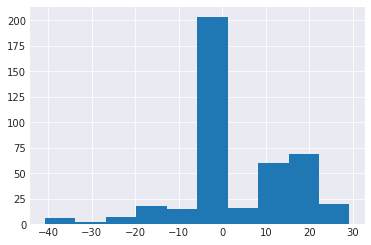

In [298]:
diff_ptiles = []
for _, r in summarize_mcmc3_with_helpers.iterrows():
    test_dat = np.random.normal(r['infino_mean'], r['infino_std'], 1000)
    test_ptile = percentileofscore(a=test_dat, score=r['cb_estimate'], kind='weak')
    diff_ptile = test_ptile - r['cb_percentile']
    diff_ptiles.append(diff_ptile)
plt.hist(diff_ptiles)